# AUTOMATIC IDENTIFICATION OF UNPLANNED HOSPITAL RE-ADMISSIONS

## INTRODUCTION
“*An unplanned readmission is where a patient, who has been previously treated in hospital, has to return to the same hospital as an emergency within 31 days of being discharged for a problem related to their original treatment.*” [Private Healthcare Information Network (PHIN)]

Unplanned readmissions are negative indicators of care, often indicating situations where patients were discharged prematurely, or highlighting potential complications following treatment. Despite the implementation of robust preventative measures, unplanned readmissions can occasionally occur. It is essential for hospitals to have systems in place to minimise their frequency and manage these events effectively. It is thus important for healthcare provider to consistently record unplanned readmissions, and to report their occurrences to regulatory bodies such as the Care Quality Commission (CQC) or PHIN.

However, the identification of a readmission as planned or unplanned is not always trivial. Currently, many organisations rely on a manual process for identifying these cases. This process requires classifications to be objective and consistent, with evaluations performed by governance and clinical teams rather than consultants involved in patient care.
In my organisation, the classification consist of a manual workflow involving a double-validation step, where governance teams meticulously review each case. While thorough, this approach is time-intensive, diverting valuable resources away from other critical governance tasks. Moreover, manual classification often lacks consistency across sites, particularly in nuanced cases, leading to discrepancies in reporting between hospitals.

To address these challenges, a machine learning (ML) model can be developed to predict whether each case is planned or unplanned based on various parameters. By leveraging existing manually classified data and enriching it with additional information from electronic health record (EHR) systems, such a model could offer an automated, objective, and consistent classification process. This approach would provide numerous benefits, including substantial time savings by streamlining the classification process and improving consistency through a data-driven methodology. Automating this task would enable governance teams to focus on more critical activities while ensuring uniformity in classification across different sites.


In this notebook, I will:
- run an exploratory data analysis (EDA) on the dataset
- test a few different algorithms to identify the best one to use for this calssification task
- evalute the results
- draw conclusions and reflect on the next steps.


For additional information please read the **README** file.






In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

np.random.seed(0)

## EXPLORATORY DATA ANALYSIS (EDA)



First of all let's import the dataset. As specified in the README file, this data cannot be made available publicly for privacy reasons. Therefore, I will use the next paragraph to describe in detail the composition of the dataset  and what it contains (by showing a dummy extract), before running an exploratory data analysis.

Please refer to the DataSheet in the README file for further information around the origin of this dataset, its motivation, composition, collection, preprocessing and use cases.

### IMPORT AND INSPECT THE DATASET

In [3]:
file_path = 'data_set_export_2024_12_07.xlsx'
original_df = pd.read_excel(file_path, engine='openpyxl')

# Check the number of rows and columns of the dataset
print(original_df.shape)

# Print the names of the columns included in the dataset
print(original_df.columns)


(5706, 29)
Index(['UnitNumber', 'AccountNumber', 'FacilityID', 'LocationID',
       'InpatientServiceID', 'zAdmitConsultantID', 'AdmissionPriority',
       'ReasonForVisit', 'AdmissionDateTime', 'Prev_DischargeDateTime',
       'Days_of_Diff_PrevDis', 'Prev_LocationID', 'Prev_ServiceID',
       'Prev_AccountNumber', 'Prev_ReasonForVisit', 'Prev_AdmitConsultant',
       'f_TF', 'f_who', 'f_Comments', 'DisagAudit', 'AttendConsultantID',
       'Sex', 'FinancialClassID', 'RaceID', 'DischargeDateTime_derived',
       'Prev_AttendConsultantID', 'Prev_AdmissionDateTime', 'n_thvis_new',
       'Prev_n_thvis'],
      dtype='object')


In order to display the format of the dataset used, I am going to import an extract containing dummy data, just to provide an example of the original dataset.

In [5]:
# Inspect the first few rows of the (dummy) dataset
dummy_df = pd.read_excel('/content/drive/MyDrive/ML_AI_course/capstone_project/data_set_example.xlsx', engine='openpyxl')

dummy_df.head(10)


,UnitNumber,AccountNumber,FacilityID,LocationID,InpatientServiceID,zAdmitConsultantID,AdmissionPriority,ReasonForVisit,AdmissionDateTime,Prev_DischargeDateTime,...,AttendConsultantID,Sex,Prev_AdmissionDateTime,DischargeDateTime_derived,FinancialClassID,RaceID,BirthDateTime,Prev_AttendConsultantID,n_thvis_new,Prev_n_thvis
0,X1,A10,H1,L1,ONCMED,1ce3cff3142569ff16723b71cc87b015,Elective,IV FLUIDS BLOOD TRANSFUSION = NEUTROPENIC,2024-05-06 18:38:00,2024-04-22 21:02:00.096,...,1ce3cff3142569ff16723b71cc87b015,F,2024-04-16 21:02:00.096,2024-05-13 18:38:00.096,PPP,OTH,1970-05-06,1ce3cff3142569ff16723b71cc87b015,0,0
1,X2,A20,H2,L4,GEN,46426ff03a6db63b58b1dc18c228fbc3,Elective,BALLOON DILATATION,2019-04-22 12:30:00,2019-04-21 17:17:59.712,...,46426ff03a6db63b58b1dc18c228fbc3,M,2019-04-18 17:17:59.712,2019-04-24 12:29:59.712,FR-Other,WHITEOT,1956-04-22,39578c35efd07fe23f005967f1c7eb28,1,2
2,X3,A30,H2,L7,ONC,7130319cf9a8a1514a506b6deec3ac5f,Elective,CYCLOPHOSPHAMIDE INFUSION,2017-09-30 09:51:00,2017-09-15 21:51:00.288,...,7130319cf9a8a1514a506b6deec3ac5f,F,2017-09-13 21:51:00.288,2017-10-14 09:51:00.288,BUPA,WHITEOT,2002-09-30,7130319cf9a8a1514a506b6deec3ac5f,0,0
3,X4,A40,H4,L5,BREASUR,0da368997efeaeab55b85652ba4eb174,Elective,LEFT RE-EXCISION,2023-10-11 06:16:00,2023-09-14 11:03:59.904,...,0da368997efeaeab55b85652ba4eb174,F,2023-09-03 11:03:59.904,2023-11-11 06:15:59.904,NORWICH,OTH,2009-10-11,0da368997efeaeab55b85652ba4eb174,1,1
4,X5,A50,H2,L9,ONCMED,5a06ed16cc368351e5d3a779c3375ed1,Unplanned Out of Hours,GENERALLY UNWELL,2022-02-24 14:02:00,2022-02-12 18:49:59.808,...,5a06ed16cc368351e5d3a779c3375ed1,F,2022-01-29 18:49:59.808,2022-03-27 14:01:59.808,KUWAIT,MIDDLEEAST,2014-02-24,5a06ed16cc368351e5d3a779c3375ed1,0,0
5,X6,A60,H3,L10,ONCMED,f8244b998f8b6c4251f1f0781bb48afb,Elective,Treatment Intermediate,2024-04-28 10:00:00,2024-04-21 22:00:00.288,...,f8244b998f8b6c4251f1f0781bb48afb,F,2024-04-05 22:00:00.288,2024-05-05 10:00:00.288,UK-SP,NOTSTATED,2009-04-28,f8244b998f8b6c4251f1f0781bb48afb,0,0
6,X7,A70,H3,L1,GASMED,3227ab67d7297de6423f3d1107899100,Elective,.URSTEKINUMAB INFUSION,2019-11-22 10:43:00,2019-11-03 17:55:00.192,...,3227ab67d7297de6423f3d1107899100,M,2019-10-27 17:55:00.192,2019-11-24 10:43:00.192,VITALITY,OTH,1942-11-22,3227ab67d7297de6423f3d1107899100,0,1
7,X8,A80,H6,L4,HAEMED,19355da44ddf26f7cbacb9dae8960344,Elective,Carfilzomib D16,2020-10-26 12:03:00,2020-10-25 16:50:59.712,...,19355da44ddf26f7cbacb9dae8960344,M,2020-10-19 16:50:59.712,2020-10-29 12:02:59.712,WPA,WHITEOT,1955-10-26,19355da44ddf26f7cbacb9dae8960344,0,0
8,X9,A90,H5,L3,ONCMED,5a06ed16cc368351e5d3a779c3375ed1,Unplanned,post chemo diarhea,2018-12-11 13:44:00,2018-12-06 23:19:59.808,...,5a06ed16cc368351e5d3a779c3375ed1,F,2018-12-01 23:19:59.808,2019-01-11 13:43:59.808,BUPA,NOTSTATED,1994-12-11,5a06ed16cc368351e5d3a779c3375ed1,0,1
9,X10,A100,H6,L6,CARMED,a02895a11b06891a53b1149cedc88e22,Unplanned,Coronary Angiogram +/- PCI K5020,2020-02-15 14:14:00,2020-01-20 14:14:00.384,...,a02895a11b06891a53b1149cedc88e22,F,2020-01-09 14:14:00.384,2020-03-03 14:14:00.384,SP,NOTSTATED,1942-02-15,a02895a11b06891a53b1149cedc88e22,1,1


### FEATURE ENGINEERING



In my analysis I want to include additional derived features, that I believe might increase the accuracy of my model. These are:
- age at admission
- boolean to indicate whether the new admitting consultant was the same as the admitting consultant in the previous episode of care
- boolean to indicate whether the new attending consultant was the same as the attending consultant in the previous episode of care
- boolean to indicate whether the service line of the new admission was the same as the service line of the previous admission (e.g. cardiac and cardiac)
- boolean to indicate whether the new ward where the patient was admitted was the same ward of the previous admission
- Day of the week of the new admission
- Time of the day of the new admission
- Day of the week of the previous admission
- Time of the day of the previous admission


In [ ]:

original_df = original_df.assign(
    age = lambda x: (pd.to_datetime(x['AdmissionDateTime']) - pd.to_datetime(x['BirthDateTime'])).dt.days // 365,
    has_same_admit_cons = lambda x: x['zAdmitConsultantID'] == x['Prev_AdmitConsultant'],
    has_same_attend_cons = lambda x: x['AttendConsultantID'] == x['Prev_AttendConsultantID'],
    dow_prev_disch = lambda x: pd.to_datetime(x['Prev_DischargeDateTime']).dt.day_name(),
    time_prev_disch = lambda x: pd.to_datetime(x['Prev_DischargeDateTime']).dt.hour,
    dow_new_adm = lambda x: pd.to_datetime(x['AdmissionDateTime']).dt.day_name(),
    time_new_adm = lambda x: pd.to_datetime(x['AdmissionDateTime']).dt.hour,
    has_same_service = lambda x: x['InpatientServiceID'] == x['Prev_ServiceID'],
    has_same_location = lambda x: x['LocationID'] == x['Prev_LocationID']
)

Below is a detailed description of each columns contained in the dataset, with details on whether the column was 'engineered' from 2 original columns and if so, how it was calculated.

| Column Name | Class | Description | Engineered/how|
|---|---|---|---|
| UnitNumber | character | Patient ID (lifetime number) |No|
| AccountNumber | character | Episode of Care ID of the new admission|No|
| FacilityID | character | Hospital ID |No|
| LocationID | character | Ward ID of the new admission|No|
| InpatientServiceID | character | ServiceLine (e.g. cardiac, oncology ...) of the new admission|No|
| zAdmitConsultantID | character | Admitting Consultant ID of the new admission|No|
| ReasonForVisit | character | Free text detailing the reason for the new admission| No|
| AdmissionDateTime | datetime | DateTime of the new admission| No|
| Prev_DischargeDateTime | datetime | DateTime of the previous hospital discharge| No|
| Days_of_Diff_PrevDis | numeric | No. of days between previous discharge and new admission| No|
| Prev_LocationID | character | Ward ID of the previous admission| No|
| Prev_ServiceID | character | ServiceLine (e.g. cardiac, oncology ...) of the previous admission| No|
| Prev_AccountNumber | character | Episode of Care ID of the previous admission| No|
| Prev_ReasonForVisit | character | Free text detailing the reason for the previous admission| No|
| Prev_AdmitConsultant | character | Admitting Consultant ID of the previous admission| No|
| f_TF | boolean | Result of the manual classification: TRUE is the new admission is 'Unplanned'<br> and related to the previous episode; <br>FALSE if the new admission is planned or not related to the previous episode| No|
| f_who | character | ID of the person  that classified this case| No|
| f_Comments | character | Free text with the comments of the person that classified this case| No|
| DisagAudit | boolean | In case of double validation, this flag is TRUE if the the independent classifiers initially disagreed;<br> FALSE if they never disagreed on the classification of the case| No|
| AttendConsultantID | character | Admitting Consultant ID of the new admission| No|
| Sex | character | Patient's biological gender: F if female, M if male| No|
| Prev_AdmissionDateTime | datetime | DateTime of the previous admission| No|
| DischargeDateTime_derived | character | DateTime of the new hospital discharge| No|
| FinancialClassID | character | Payer type (e.g. self-pay, insurance, embassy ...)| No|
| RaceID | character | Patient's ethnicity| No|
|los_days|numeric| No. of days spent in the hospital in the new episode |Yes: calculated as number of days between AdmissionDateTime and DischargeDateTime_derived	|
|Prev_los_days|numeric| No. of days spent in the hospital in the previous episode|Yes: calculated as number of days between Prev_AdmissionDateTime and Prev_DischargeDateTime_derived	|
|Prev_AttendConsultantID|character|Admitting Consultant ID of the new admission|
|n_thvis_new|numeric|No. of theatre visits in the new admission (i.e. is this a surgical patient)|No|
|Prev_n_thvis|numeric|No. of theatre visits in the previous admission|No|
|age|numeric| Patient's age at admission (new)|Yes: calculated using Date of Birth and AdmissionDateTime|
|has_same_admit_cons|boolean|TRUE is the admitting consultant of the new admission is the same of the previous one;<br> FALSE otherwise|Yes: calculated by comparing the admitting consultant between the 2 episodes|
|has_same_attend_cons|boolean|TRUE is the attending consultant of the new admission is the same of the previous one;<br> FALSE otherwise|Yes: calculated by comparing the attending consultant between the 2 episodes|
|dow_prev_disch|character|Day of the week of the previous discharge|Yes: calculated by extracting the day of the week from the Prev_DischargeDateTime|
|time_prev_disch|numeric|Time of the day of the previous discharge|Yes: calculated by extracting the hour from the Prev_DischargeDateTime|
|dow_new_adm |character|Day of the week of the new admission|Yes: calculated by extracting the day of the week from the AdmissionDateTime|
|time_new_adm |numeric|Time of the day of the new discharge|Yes: calculated by extracting the hour from the AdmissionDateTime|
|has_same_service |boolean|TRUE is the service line of the new admission is the same of the previous one;<br> FALSE otherwise|Yes: calculated by comparing the service line between the 2 episodes|
|has_same_location|boolean|TRUE is the location (ward) of the new admission is the same of the previous one;<br> FALSE otherwise|Yes: calculated by comparing the location of admission between the 2 episodes|


A few of the columns included in the original dataset, won't add any value to the analysis, as their essence has been incorporated via the engineered features (e.g. the name of the specific consultant that attended the patient, or the specific dates of admission / discharge), or are columns that wouldn't be available for new episodes (e.g. Comments from the goverance team noted when performing the manual classification). Therefore, I will remove these columns from the dataframe.
I will retain columns like LocationID and FacilityID as they can serve as proxies or indicators of the level of care complexity. Specific locations or facilities might correlate with the type of healthcare challenges encountered (e.g., specialised centers dealing with high-acuity patients).


In [6]:
# Remove columns that are not needed
columns_to_remove = ['UnitNumber',
                     'AccountNumber', 'Prev_AccountNumber',
                     'f_who', 'f_Comments', 'DisagAudit',
                     'AdmissionDateTime', 'Prev_AdmissionDateTime',
                     'DischargeDateTime_derived', 'Prev_DischargeDateTime',
                     'zAdmitConsultantID', 'Prev_AdmitConsultant',
                     'Prev_AttendConsultantID', 'AttendConsultantID',
                     'ReasonForVisit', 'Prev_ReasonForVisit'] # these last 2 have been removed only for lack of time. I will include them in future steps but I'll have to run NLP on them

df_clean = original_df.drop(columns=columns_to_remove)

print(df_clean.columns)
print(df_clean.shape)

Index(['FacilityID', 'LocationID', 'InpatientServiceID', 'AdmissionPriority',
       'Days_of_Diff_PrevDis', 'Prev_LocationID', 'Prev_ServiceID', 'f_TF',
       'Sex', 'FinancialClassID', 'RaceID', 'los_days', 'Prev_los_days',
       'n_thvis_new', 'Prev_n_thvis', 'age', 'has_same_admit_cons',
       'has_same_attend_cons', 'dow_prev_disch', 'time_prev_disch',
       'dow_new_adm', 'time_new_adm', 'has_same_service', 'has_same_location'],
      dtype='object')
(5706, 24)


To ensure the column containing the labelled value (the one I am trying to predict) is not included in the training of the models, I will move it to index 0. This will make it easy to identify throughout the analysis and ensure I remember to remove it.

In [7]:
output_column = 'f_TF'
new_order = [output_column] + [col for col in df_clean.columns if col != output_column]
df_clean = df_clean[new_order]

I will also transform the output column, '*f_TF*' into a boolean, as at the moment it has been evaluated as an integer with values 0 or 1.

In [8]:
df_clean['f_TF'] = df_clean['f_TF'].astype(bool)

In [9]:
df_clean['f_TF'].unique()

array([False,  True])

Despite most of the data cleaning on the dataset had been performed before importing it into this notebook, I want to make sure that the rows that have been selected do not contain any null values.

In [10]:
print(len(df_clean))
df_clean = df_clean.dropna()
print(df_clean.shape)

5706
(5706, 24)


### INSPECT EACH VARIABLE



Below I will look at the distribution of each variable individually, the presence of potential outliers, and I will then evaluate correlations between variables.



#### **Numerical Features**

I will use the `describe()` method to get a summary of the descriptive statistics for all numerical features in the dataframe.

In [11]:
df_clean.describe()

,Days_of_Diff_PrevDis,los_days,Prev_los_days,n_thvis_new,Prev_n_thvis,age,time_prev_disch,time_new_adm
count,5706.000000,5706.000000,5706.000000,5706.000000,5706.000000,5706.000000,5706.000000,5706.000000
mean,10.224448,4.369870,3.762729,0.375394,0.554504,53.944444,15.774448,13.532948
std,8.290742,10.354653,7.922614,0.711974,0.706493,18.811773,3.327276,4.642076
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,0.341840,0.308333,0.000000,0.000000,41.000000,13.000000,10.000000
50%,7.600000,1.769097,1.221528,0.000000,0.000000,55.000000,16.000000,13.000000
75%,15.200000,4.865278,4.302604,1.000000,1.000000,68.000000,18.000000,17.000000
max,31.000000,462.783333,284.256250,10.000000,14.000000,103.000000,23.000000,23.000000


I will also use box plots to look at the distribution of numerical data, and identify potential outliers.

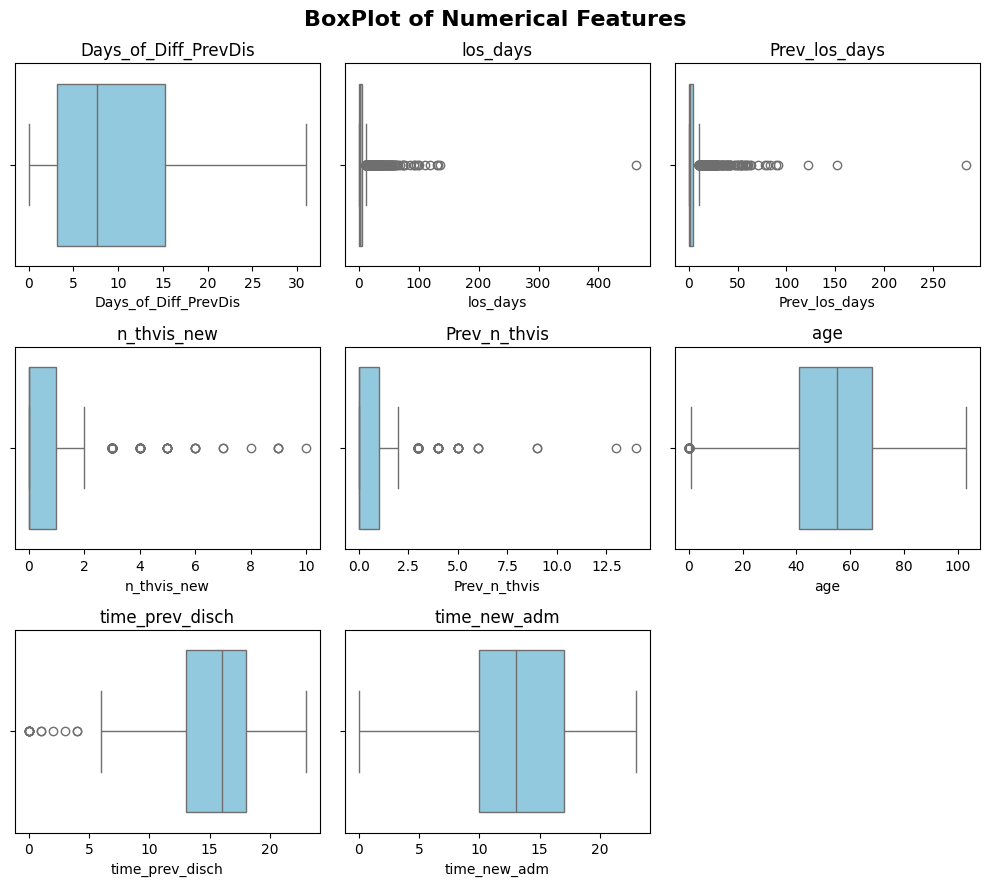

In [ ]:
numerical_cols = df_clean.select_dtypes(include=['number']).columns
num_rows = int(np.ceil(len(numerical_cols) / 3))
fig, axes = plt.subplots(num_rows, 3, figsize=(10, num_rows * 3))
axes = axes.flatten()

plt.suptitle("BoxPlot of Numerical Features", fontsize=16, fontweight='bold')

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df_clean[col], ax=axes[i], color = "skyblue")
    axes[i].set_title(col)

for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


The *los* (lenght of stay) variables seems to have quite a few outliers, similarly to number of theatre visits (*n_thvis*) and, in reduced measure, *age*.

However, removing outliers from a healthcare dataset used for ML should be approached with caution due to several reasons:
- Outliers may represent real and critical cases. After sampling some of these outliers, and checking on the medical records of these patients, I got reassured that they were indeed real cases and not a data entry issue.
- Impact on model generalisation: by training ML models on sanitised version of real datasets, we risk making the model less robust to unusual but realistic scenarios, reducing the applicability of the model.
- Bias introduction: removing outliers could bias the dataset, leading to a model that performs well on the remaining data but fails to predict for edge cases or underrepresented cohorts.

Therefore, I decided not to remove any of these outliers and train my models on the full dataset.

Another way of visualising distributions is to leverage histogram plots.

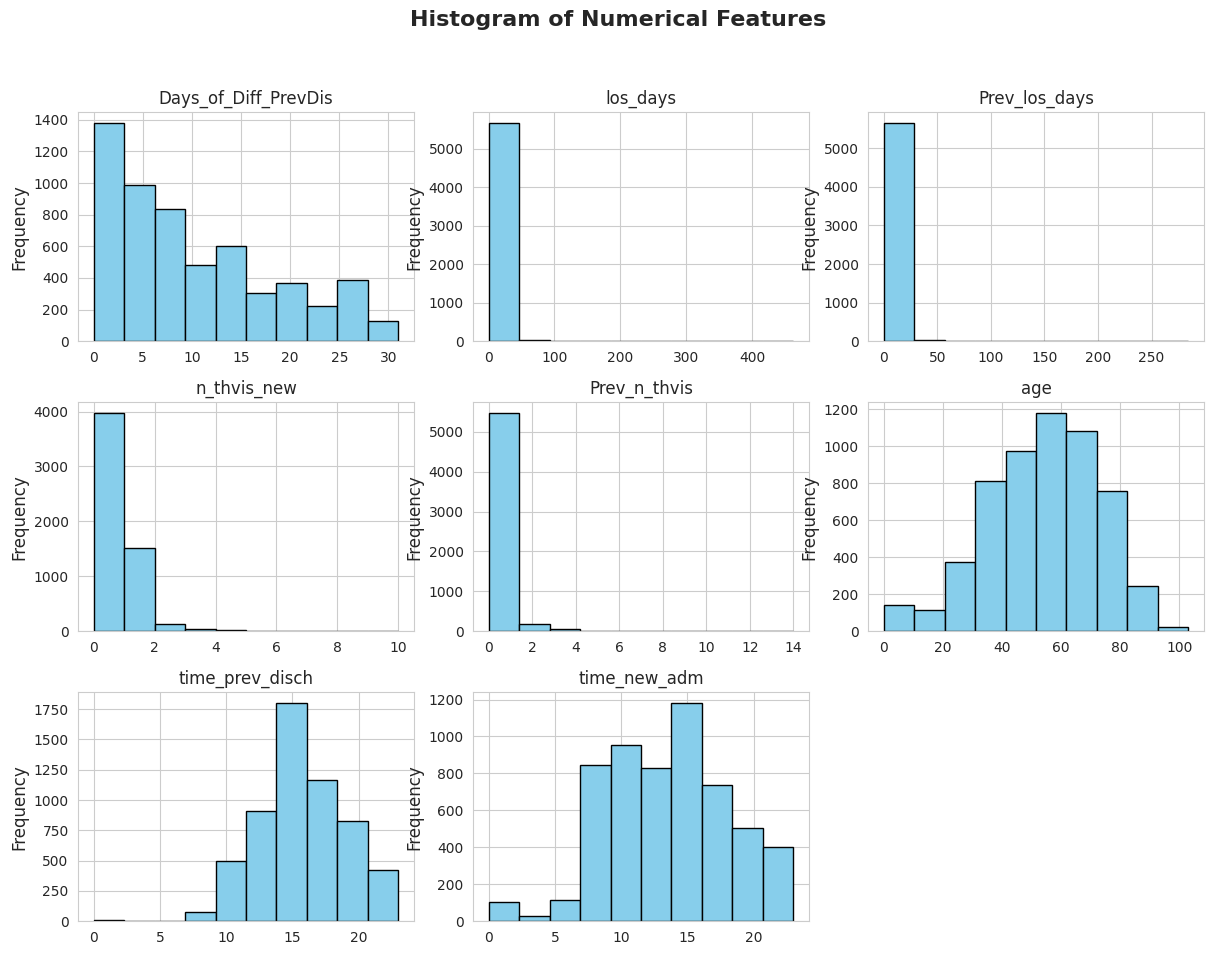

In [ ]:
sns.set_style("whitegrid")

df_clean.hist(figsize=(12, 10), color='skyblue', edgecolor='black')

plt.suptitle("Histogram of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in plt.gcf().axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

plt.show()

#### **Output Feature**

I will now check the distribution of `True(s)` and `False(s)` in the output column, '*f_TF*' to make sure it is split equally. This step has been preformed before importing the full dataset in this Jupyter notebook for the analysis.

To achieve an equal split, I started by looking at all cases that had been manually classified since 2017. I removed any case that had missing values, and looked at the initial distribution of `True(s)` and `False(s)`.

The original dataset had 37'756 `False` (Planned) cases and 2'853 `True` (Unplanned) cases. This distribution was very skewed (93%-7%), but since the dataset was large enought to run a ML model, I decided to use a **sub-sampling approach** achieving a balanced split by **randomly removing examples from the majority class**. This approach can be effective when the dataset is large and the majority class contains many redundant or similar samples.

Therefore, I kept all `True` cases, and randomly selected 2'853 `False` cases, after making sure that any case with missing data had been already removed from the original dataset.

In [12]:
df_clean['f_TF'].value_counts()

,count
f_TF,
False,2853
True,2853


#### **Other Categorical Features**

For the categorical features, I will first use the `value_counts()` method to see the frequency of each category per variable. I will then use bar charts to visualise the distribution of the top10 categories per variable.

In [ ]:
for column in df_clean.select_dtypes(include=['object']):
  print('----', column, '----')
  print(df_clean[column].value_counts())
  print('\n')

---- FacilityID ----
FacilityID
4e8ddf74d7619c2ac00f8e2e1df073a6    957
ee9c0baac0c049c838426b274e69df99    936
82ea9d57f29843896b6489dc49451b8b    801
9f714ece2ec57423fea8026df79c7f01    780
c66b179a6b637b2398a47258564e5685    749
9ce11bf985fd8d8535a10b01a9ce7e15    474
e78ecbab9c8e1eace9fec46dabd81c30    376
a8c6f2d9be405fbb26c087cbbdd2bc51    289
ed7e8408cd87ca379adc53627e836a90    229
d284e885263d5ba7ea6a7eac4db4d6eb     61
061bd02602c60b73bf88f298fccc1674     34
9e4588536c68b368195e2141e2328eaf     14
9a7b38fb4ddb4a0f43ec6b337d88976f      4
8d5bac07d4dd7a6118e9448f11367db5      2
Name: count, dtype: int64


---- LocationID ----
LocationID
cc8750e106319c4208d376c247f2d3a8    687
f43ba37ec5359390f6e1652dc6c526f8    356
39cdc0579a903c0f657fef4eaf216211    270
7a3af9bfcb2a390f47204909b544c2d3    267
257dc262437cfc8edb05e20128e26421    237
                                   ... 
f3b07ae0c0c7cc3646661c21fdaa892d      1
a6874eb68e70367c501376d70cf6329b      1
7852c1c1f4078fd9e7d155cab483

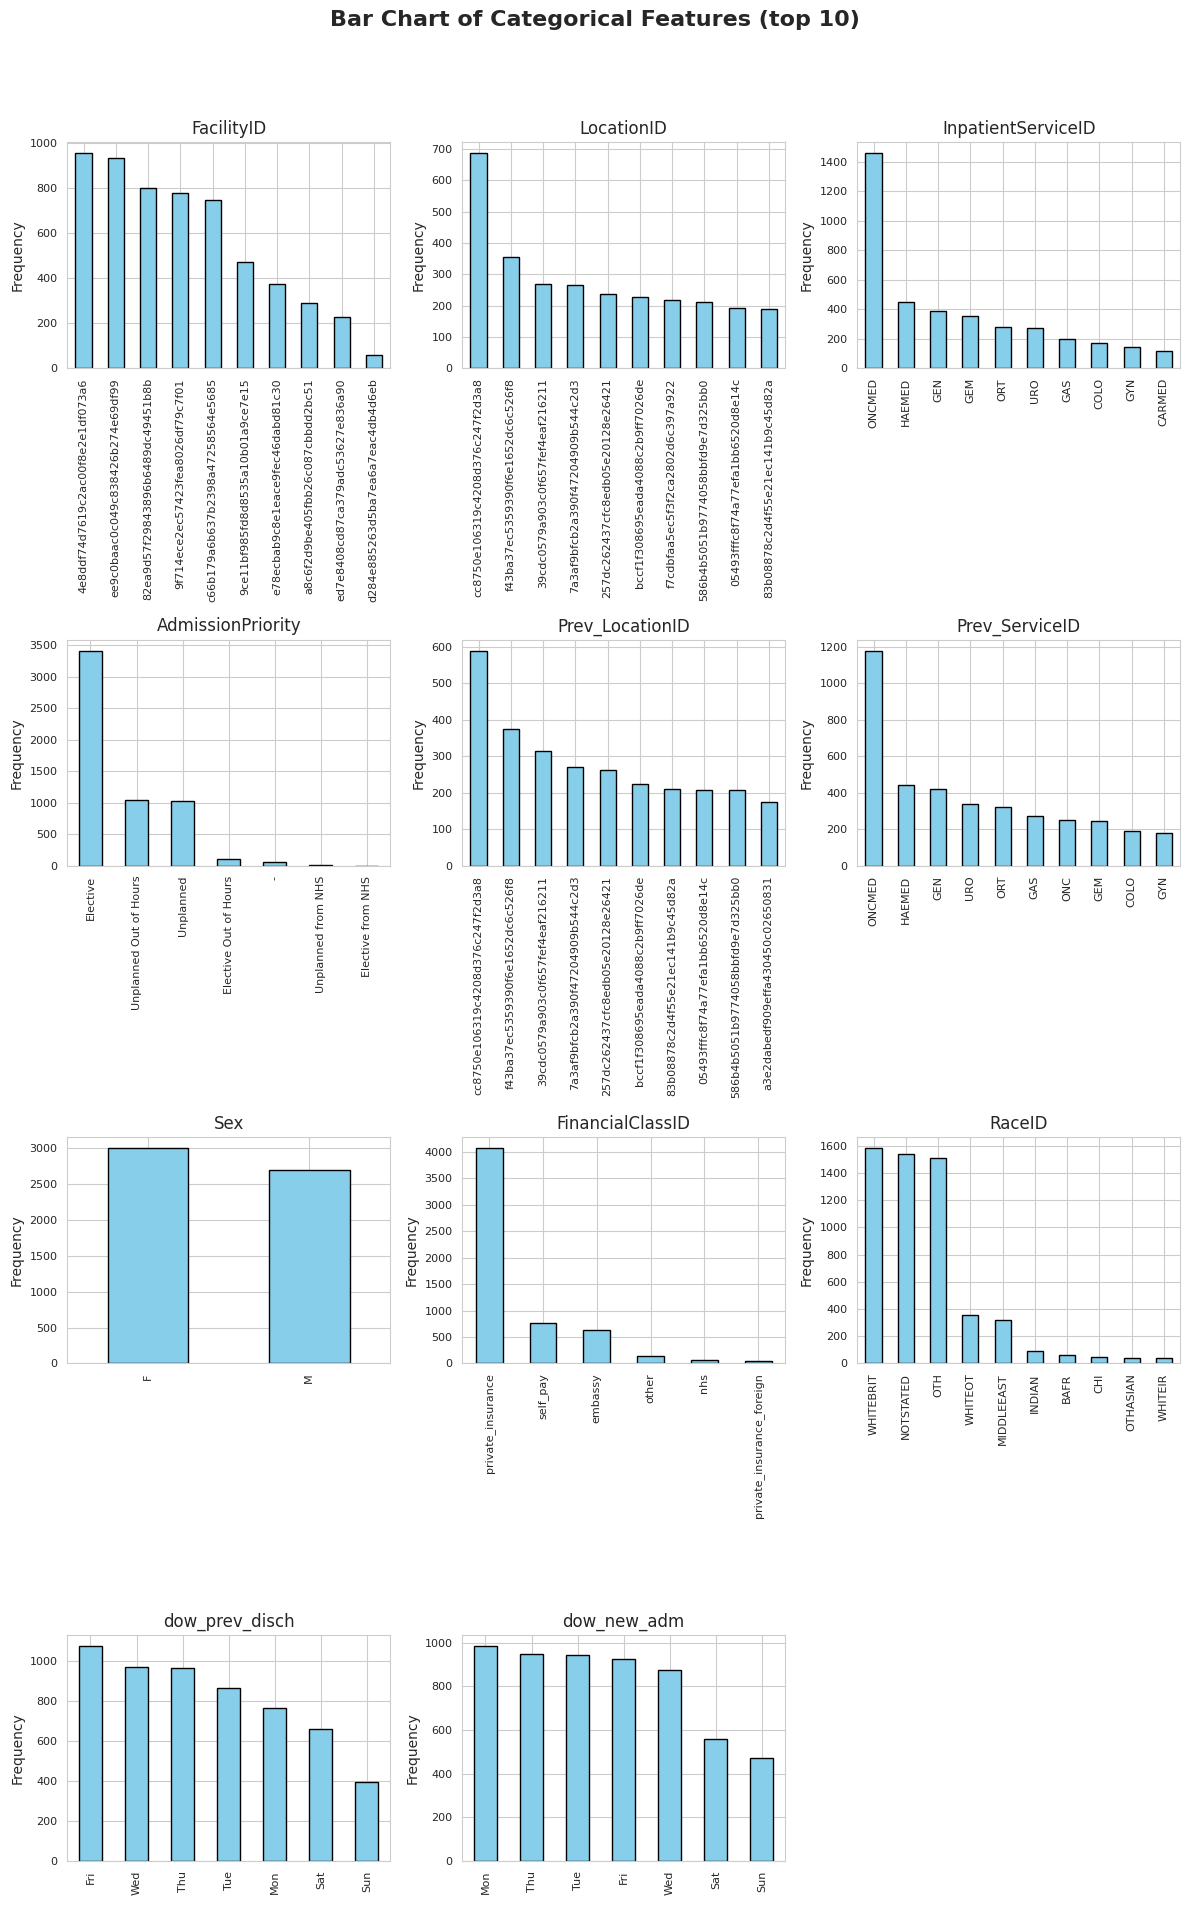

In [ ]:
categorical_cols = df_clean.select_dtypes(include=['object']).columns
num_rows = int(np.ceil(len(categorical_cols) / 3))
fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 5))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Get value counts and select top 10 if more than 10 categories
    value_counts = df_clean[col].value_counts()
    if len(value_counts) > 10:
        value_counts = value_counts[:10]  # Select top 10

    value_counts.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Bar Chart of Categorical Features (top 10)", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### CORRELATION MATRIX



The heatmap below shows the correlation between all numerical features in the dataframe (using the default Pearson correlation coefficient), with the colour of the cell indicating the strength and direction of the correlation: darker blue represents a stronger positive correlation, and lighter green represents a weaker correlation or no correlation.

Correlation does not imply causation. While the matrix shows associations between variables, it doesn't necessarily mean that one variable causes changes in another.
The matrix only considers linear relationships: non-linear relationships might exist between variables, but wouldn't be captured by the correlation coefficient.

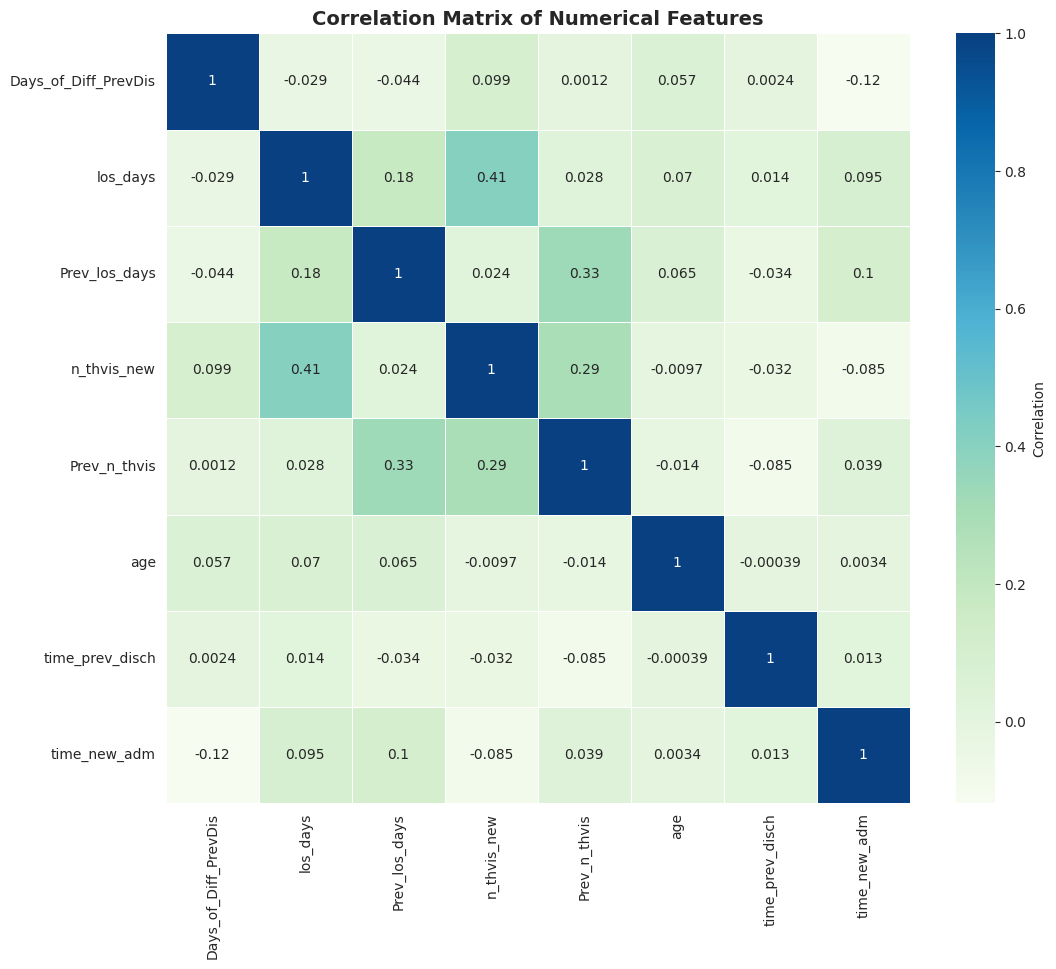

In [ ]:
numerical_cols = df_clean.select_dtypes(include=['number']).columns
corr_matrix = df_clean[numerical_cols].corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, cmap="GnBu",
            linewidths=.5,
            cbar_kws={'label': 'Correlation'})

plt.title("Correlation Matrix of Numerical Features", fontsize=14, fontweight='bold')

plt.show()


The pairs of variables with the higher (nonetheless weak) correlations are:

- *Prev_los_days* (length of stay in previous episode) and *Prev_n_thvis* (number of theatre visits in previous admission)
-*los_days* (length of stay in the new admission) and *n_thvis_new* (number of theatre visits in the new admission)
-*n_thvis_new* (number of theatre visits in the new admission) and *Prev_n_thvis* (number of theatre visits in previous admission)

Most other pairs of variables show weaker or no correlation (lighter green or white), indicating that there is little to no linear relationship between them.

The weak correlations reported by the heatmap above suggests reduced multicollinearity between variables. This property is particular beneficial for models like Logistic Regression and Support Vector Machines, that are highly affected by multicollinearity.
Also, tree-based models (e.g., Random Forest, Gradient Boosting) and ensemble methods are robust to weak correlations, as they can capture non-linear relationships even when correlations are weak.

Features with weak correlations often carry unique, non-redundant information, so models can benefit from this diversity to make better predictions, as the features are likely contributing independently to the target variable.


### HANDLE CATEGORICAL PREDICTORS



In most of the well-established machine learning systems, categorical variables are handled naturally. However, when dealing with decision trees, we need to encode (translate) categorical features into numerical features.

Arguably, the easiest way to achieve this is by using the `pandas` function `get_dummies()` that converts categorical variables into dummy/indicator variables.

I will first identify the categorical variables, and then use the `get_dummies()` function on these variables.



In [ ]:
# first identify the categorical variables

for column in df_clean.columns:
    print(f'{column}: {df_clean[column].dtype}')


f_TF: bool
FacilityID: object
LocationID: object
InpatientServiceID: object
AdmissionPriority: object
Days_of_Diff_PrevDis: float64
Prev_LocationID: object
Prev_ServiceID: object
Sex: object
FinancialClassID: object
RaceID: object
los_days: float64
Prev_los_days: float64
n_thvis_new: int64
Prev_n_thvis: int64
age: int64
has_same_admit_cons: bool
has_same_attend_cons: bool
dow_prev_disch: object
time_prev_disch: int64
dow_new_adm: object
time_new_adm: int64
has_same_service: bool
has_same_location: bool


In [90]:
df_analysis = pd.get_dummies(df_clean, columns=['FacilityID', 'LocationID', 'InpatientServiceID',  'AdmissionPriority',
                                                'Prev_LocationID', 'Prev_ServiceID', 'Sex', 'FinancialClassID', 'RaceID',
                                                'dow_new_adm', 'dow_prev_disch'], drop_first=True)
print(df_analysis.shape)
df_analysis.head()

(5706, 416)


,f_TF,Days_of_Diff_PrevDis,los_days,Prev_los_days,n_thvis_new,Prev_n_thvis,age,has_same_admit_cons,has_same_attend_cons,time_prev_disch,...,dow_new_adm_Sun,dow_new_adm_Thu,dow_new_adm_Tue,dow_new_adm_Wed,dow_prev_disch_Mon,dow_prev_disch_Sat,dow_prev_disch_Sun,dow_prev_disch_Thu,dow_prev_disch_Tue,dow_prev_disch_Wed
0,False,6.5,0.541667,1.131250,0,1,58,True,True,10,...,False,False,False,False,False,False,True,False,False,False
1,False,24.8,28.303472,0.966667,2,1,59,True,True,12,...,False,False,True,False,False,False,False,False,False,False
2,False,14.8,3.036806,0.315278,0,0,76,False,True,20,...,False,False,False,True,False,False,False,False,True,False
3,False,17.7,0.365278,5.491667,0,1,61,False,False,19,...,False,False,False,True,False,True,False,False,False,False
4,False,1.2,21.950694,0.208333,2,1,71,True,True,13,...,False,True,False,False,False,False,False,False,False,True


## SPLIT INTO TRAIN, VALIDATION AND TEST DATASET


I will now split the dataset into training (70%), validation (15%), and test (15%) sets to ensure a robust evaluation and optimisation process: the training set will be used to train the model, the validation set will help fine-tune hyperparameters and prevent overfitting, and the test set will provide an unbiased assessment of the model's performance on unseen data.

The dataset split will be performed randomly to ensure that each subset (training, validation, and test) is representative of the overall dataset. This randomness helps prevent bias in the subsets, ensuring that the model generalises well and is not inadvertently optimised for a particular pattern or sequence in the data.

In [91]:
# Transform the dataset into a NP array, and shuffle it
Xy = np.array(df_analysis)
np.random.shuffle(Xy)

Now split the predictors (X) and response variable (y).

Recall that the response variable (f_TF) had previously been stored in the first column of the dataframe.

In [92]:
X = Xy[:, 1:]
X

array([[29.0, 3.288888888888889, 0.1541666666666667, ..., True, False,
        False],
       [17.7, 3.170138888888889, 1.395833333333333, ..., False, False,
        True],
       [2.7, 41.30694444444445, 0.3916666666666667, ..., False, False,
        False],
       ...,
       [10.2, 4.238888888888889, 2.058333333333333, ..., False, False,
        True],
       [6.1, 0.9201388888888888, 0.9979166666666667, ..., False, False,
        False],
       [15.9, 4.083333333333333, 8.025, ..., False, False, True]],
      dtype=object)

The response variable was already of boolean type, but the line below makes sure that I still have a boolean, in case any of the transformations applied above changed it.

In [93]:
y = Xy[:,0]
y = y.astype(bool)

In [94]:
# Split into train and remaining (validation + test) 70-30
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=42)

# Split remaining into validation and test 15-15
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)  # 0.5 for equal split

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3994, 415) (856, 415) (856, 415)
(3994,) (856,) (856,)


In [95]:
# check that the split worked as expected
print("Training set:", len(X_train), len(y_train))
print("Validation set:", len(X_val), len(y_val))
print("Test set:", len(X_test), len(y_test))

Training set: 3994 3994
Validation set: 856 856
Test set: 856 856


I now want to check that both classes are represented in the train, validation and test sets.

In [96]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train split:")
for i in range(len(unique_train)):
  print(f"  {unique_train[i]}: {counts_train[i]} ({counts_train[i] / len(y_train) * 100:.2f}%)")

unique_val, counts_val = np.unique(y_val, return_counts=True)
print("\ny_val split:")
for i in range(len(unique_val)):
  print(f"  {unique_val[i]}: {counts_val[i]} ({counts_val[i] / len(y_val) * 100:.2f}%)")

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\ny_test split:")
for i in range(len(unique_test)):
  print(f"  {unique_test[i]}: {counts_test[i]} ({counts_test[i] / len(y_test) * 100:.2f}%)")

y_train split:
  False: 2019 (50.55%)
  True: 1975 (49.45%)

y_val split:
  False: 426 (49.77%)
  True: 430 (50.23%)

y_test split:
  False: 408 (47.66%)
  True: 448 (52.34%)


## MODEL SELECTION




To predict whether a readmission was planned or unplanned using a labeled dataset with mixed input variable types (categorical, numerical, and boolean), I need a **supervised machine learning algorithm for binary classification** Suitable options are:

- **Decision Trees**: these can naturally handle mixed data types and do not require extensive preprocessing.
  - *Advantages*: handling of non-linear relationships and interpretability
  - *Limitations*: prone to overfitting on small datasets.
- **Tree Ensembles** (e.g. Random Forest): these improve upon decision trees by using an ensemble approach that helps in reducing overfitting thus improving generalisation. They also handle categorical data natively, so there is no need for scaling.
  - *Advantages*: robust to noise and provide feature importance scores.
- **Logistic Regression**: this is a simple and effective baseline model for binary classification tasks. To handle boolean and categorical variables I can use encoding techniques (one-hot or label encoding).
  - *Advantages*: interpretability and simplicity.
- **K-Nearest Neighbours** (kNN): this non-parametric method makes predictions based on the similarity of the data points. It requires scaling for numerical data, whilst mixed data require distance measures that combine categorical and numerical features (e.g. Gower distance).
  - *Advantages*: simple to implement and interpret.
  - *Limitations*: computationally expensive for large datasets.



Other models that I could leverage for this analysis are **Support Vector Machines, Neural Networks, Gradient Boosting Methods, Naive Bayes**.
However, I will start with the ones listed above and I will leave the others for future iterations of this analysis.

I am going to train these models on the training set, evaluate their performance on the validation set and ultimately, after tuning them I will use the test set to evaluate the accuracy on unseen data.





### DECISION TREE CLASSIFIER



Decision Trees are a very popular choise as these algorithms are extremely transparent, computationally very effective and not sensitive to noise. There is 2 approaches to deciding the order in which the features should be used to split the branches:
- SME driven
- Statistically driven (using the Gini index or entropy)

In this case, I will start with no preconcept, and I will use the latter approach.

The key hyperparameters of a decision tree are:
1. **max_depth**: maximum depth of the tree. Limiting the depth helps prevent overfitting by controlling how deep the tree can grow. Default: None (no limit on the depth). A larger depth allows the model to capture more complex patterns, but it can lead to overfitting. A smaller depth can underfit the data.
2. **min_samples_split**: minimum number of samples required to split an internal node. Default: 2. A higher value prevents the tree from growing too complex, thus reducing overfitting by requiring more samples to make a split. Lower values can lead to deeper trees with more splits.
3. **min_samples_leaf**: minimum number of samples required to be at a leaf node.
Default: 1. A larger value can help with smoothing the model and prevent overfitting by ensuring that leaf nodes have enough data. A smaller value allows the tree to be more complex.
4. **max_features**: number of features to consider when looking for the best split. Default: None (all features are used).Limiting the number of features can reduce overfitting and improve the model's generalisation. If set to "sqrt", it will use the square root of the total number of features, which is often used in random forests.
5. **criterion**: what to use to measure the quality of a split. Default: Gini. The choice of criterion influences how the splits are made, but it doesn't always lead to large differences in performance.
6. **splitter**: strategy used to split at each node. Default: best. The "best" splitter finds the optimal split at each node, while "random" can speed up the tree-building process and increase diversity in ensemble methods like random forests.
7. **max_leaf_nodes**: maximum number of leaf nodes in the tree. Default: None (unlimited). Limiting the number of leaf nodes can help control the complexity of the model and reduce overfitting.
8. **min_impurity_decrease**: A node will only be split if the impurity decrease is greater than or equal to this value. Default: 0. Increasing this value can prevent the tree from growing too deep and can be used to prune the tree by making only significant splits.
9. **class_weight**: Weights associated with classes. This can be useful for handling class imbalance by assigning higher weights to minority classes Default: None. Useful for classification tasks where classes are imbalanced.
10. **random_state**: controls the randomness of the estimator. If set to a fixed value, the model will produce the same output every time it is trained, ensuring reproducibility. Default: None. Not critical for model performance but useful for consistency in results during experimentation.
11. **max_samples**: maximum number of samples used to fit the tree, typically used with a bootstrap sampling technique (in ensemble methods like random forests). Default: None. Limits the number of training samples and can reduce the time it takes to train the model.


For the `DecisionTreeClassifier()` model, I will focus on tuning the `max_depth` hyperparameter whithin a loop using a grid search approach, whilst keeping default values for the others.

Within the loop, I will monitor the accuracy for each score. Accuracy is the proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances.


In [20]:
bestdepth = -1
bestscore = 0


for i in range(15):

    clf = tree.DecisionTreeClassifier(
        criterion = 'gini',
        splitter = 'best',
        max_depth = i+1,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = None,
        random_state = None
        )

    # fit the training sets
    clf.fit(X_train, y_train)

    # update trainscore
    trainscore = clf.score(X_train, y_train)

    # update valscore
    valscore = clf.score(X_val, y_val)

    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)

    # keep track of the best score
    if (valscore > bestscore):
        #update bestscore
        bestscore = valscore

        #update depth
        bestdepth = i + 1

Depth: 1 Train Score: 0.7120681021532298 Validation Score: 0.735981308411215
Depth: 2 Train Score: 0.7511266900350526 Validation Score: 0.764018691588785
Depth: 3 Train Score: 0.8092138207310966 Validation Score: 0.8235981308411215
Depth: 4 Train Score: 0.8347521281922884 Validation Score: 0.8376168224299065
Depth: 5 Train Score: 0.8397596394591887 Validation Score: 0.8329439252336449
Depth: 6 Train Score: 0.8565348022033049 Validation Score: 0.8282710280373832
Depth: 7 Train Score: 0.8733099649474211 Validation Score: 0.8376168224299065
Depth: 8 Train Score: 0.8913370055082624 Validation Score: 0.8387850467289719
Depth: 9 Train Score: 0.9056084126189284 Validation Score: 0.8504672897196262
Depth: 10 Train Score: 0.9183775663495243 Validation Score: 0.8481308411214953
Depth: 11 Train Score: 0.9354031046569855 Validation Score: 0.8504672897196262
Depth: 12 Train Score: 0.9486730095142714 Validation Score: 0.8481308411214953
Depth: 13 Train Score: 0.957185778668002 Validation Score: 0.84

In [21]:
print( 'Best Tree Depth:', bestdepth, '\nBest Validation Score:', bestscore)

Best Tree Depth: 9 
Best Validation Score: 0.8504672897196262


In [22]:
best_clf = tree.DecisionTreeClassifier(
        criterion = 'gini',
        splitter = 'best',
        max_depth = bestdepth,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = None,
        random_state = None
        )

best_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

Since I have no other terms of reference for now, I will compare the accuracy of my predictions with the Naive benchmark on the validation set. [taken from Module 10.1]

In [23]:
acc_train = 1 - (sum(y_train) / len(y_train))
acc_val = 1 - (sum(y_val) / len(y_val))

print ( 'Naïve guess train and validation', acc_train , acc_val)

Naïve guess train and validation 0.4982473710565849 0.48364485981308414


In [24]:
y_pred = best_clf.predict(X_val)
cm_clf = confusion_matrix(y_val, y_pred)


# Extract values from the confusion matrix
TN, FP, FN, TP = cm_clf.ravel()

# Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)

# Specificity (True Negative Rate)
specificity = TN / (TN + FP)

# Misclassification Rate (Error Rate)
misclassification_rate = (FP + FN) / (TP + TN + FP + FN)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")


Sensitivity: 0.9050
Specificity: 0.7874
Misclassification Rate: 0.1519


I can already say that the Decision Tree model returns interesting results.

Let's try using different parameters and see if I can further improve the accuracy.

In [25]:
clf2 = tree.DecisionTreeClassifier(
        criterion = 'gini',
        splitter = 'best',
        max_depth = 9,
        min_samples_split = 3,
        min_samples_leaf = 1,
        max_features = None,
        random_state = None
        )

# fit the training sets
clf2.fit(X_train, y_train)


trainscore = clf2.score(X_train, y_train)
valscore = clf2.score(X_val, y_val)

print( 'Training Score:', trainscore, '\nValidation Score:', valscore)

Training Score: 0.9053580370555834 
Validation Score: 0.8504672897196262


I have tried to change the splitter and the min_samples_split and min_samples_leaf. I did not obtain major differences, therefore I will use `clf` as my best decision tree model.

#### Test the best model
I will now use the best model on the test dataset. But first I will create a function that I can use on any model going forward, to return additional performance metrics of a classification algorithm.

In [26]:
def calculate_classification_metrics(model, X, y_true):
  """
  Calculates and prints sensitivity, specificity, misclassification rate, and accuracy.

  Args:
    model: The trained classification model.
    X: The input features for prediction.
    y_true: The true target values.
  Returns:
    sensitivity, specificity, misclassification_rate, accuracy_rate
  """

  y_pred = model.predict(X)
  cm = confusion_matrix(y_true, y_pred)
  TN, FP, FN, TP = cm.ravel()

  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)
  misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
  accuracy_rate = (TP + TN) / (TP + TN + FP + FN)

  print(f"Sensitivity: {sensitivity:.4f}")
  print(f"Specificity: {specificity:.4f}")
  print(f"Misclassification Rate: {misclassification_rate:.4f}")
  print(f"Accuracy Rate: {accuracy_rate:.4f}")

  return sensitivity, specificity, misclassification_rate, accuracy_rate

In [27]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_clf, X = X_test, y_true = y_test)

models_comparison_df = pd.DataFrame({
    'model': ['Decision Tree'],
    'model_name': ['best_clf'],
    'sensitivity': [sensitivity],
    'specificity': [specificity],
    'misclassification_rate': [misclassification_rate],
    'accuracy_rate': [accuracy_rate]
})

models_comparison_df

Sensitivity: 0.8845
Specificity: 0.7884
Misclassification Rate: 0.1659
Accuracy Rate: 0.8341


,model,model_name,sensitivity,specificity,misclassification_rate,accuracy_rate
0,Decision Tree,best_clf,0.884521,0.788419,0.165888,0.834112


### TREE ENSEBLES - RANDOM FOREST



The Random Forest algorithm is an ensemble method that builds multiple decision trees and combines their predictions. It generally improves the performance of individual decision trees by reducing overfitting and increasing generalisation.

While Decision Trees have their own set of hyperparameters (such as max_depth, min_samples_split, etc.), Random Forests introduce additional hyperparameters that are specific to managing multiple trees and their interactions. In addition to the decision tree hyperparameters, Random Forest has these key differences:
- Random Forest introduces the `n_estimators` parameter to control the number of trees in the ensemble, whereas decision trees only involve a single tree.
- The `bootstrap` and `max_samples` parameters in Random Forest control how trees are trained using random subsets of the data, which helps introduce diversity and reduce variance. Decision trees use the full dataset to train a single tree.
- Random Forest has the `oob_score` parameter, which allows the model to internally validate its predictions using out-of-bag samples, something a decision tree cannot do on its own.
- Random Forest introduces randomness in feature selection with the `max_features` parameter, which controls the number of features considered for each split. In decision trees, all features are considered for each split unless explicitly controlled with the `max_features` parameter.

I will first start by using all default parameters. Then, I will change some of the hyperparameters.

In [97]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [98]:
print ( 'Full tree guess train/validation ', rf_clf.score(X_train, y_train), rf_clf.score(X_val, y_val))

Full tree guess train/validation  1.0 0.9018691588785047


As a starting point, the Tree Enslemble model is proving more accurate than the Decision Tree model. Parameters that I will tune:
- max_features: None + sqrt
- n_estimators
- bootstrap

In [99]:
n_estimators_options = [100, 150, 200]
max_features_options = [None, "sqrt"]
bootstrap_options = [True, False]

# Store the results
results = []

# Iterate through all combinations of parameters
for n_estimators in n_estimators_options:
    for max_features in max_features_options:
        for bootstrap in bootstrap_options:

            rf_clf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                                     max_features=max_features,
                                                     bootstrap=bootstrap)

            # Fit the classifier to the training data
            rf_clf.fit(X_train, y_train)

            # Evaluate the classifier on the validation set
            val_score = rf_clf.score(X_val, y_val)

            # Print the results
            print(f"n_estimators: {n_estimators}, max_features: {max_features}, bootstrap: {bootstrap}, Validation Score: {val_score}")

            # Store the results
            results.append([n_estimators, max_features, bootstrap, val_score])


n_estimators: 100, max_features: None, bootstrap: True, Validation Score: 0.8808411214953271
n_estimators: 100, max_features: None, bootstrap: False, Validation Score: 0.8177570093457944
n_estimators: 100, max_features: sqrt, bootstrap: True, Validation Score: 0.9007009345794392
n_estimators: 100, max_features: sqrt, bootstrap: False, Validation Score: 0.8983644859813084
n_estimators: 150, max_features: None, bootstrap: True, Validation Score: 0.8843457943925234
n_estimators: 150, max_features: None, bootstrap: False, Validation Score: 0.8177570093457944
n_estimators: 150, max_features: sqrt, bootstrap: True, Validation Score: 0.9065420560747663
n_estimators: 150, max_features: sqrt, bootstrap: False, Validation Score: 0.8983644859813084
n_estimators: 200, max_features: None, bootstrap: True, Validation Score: 0.8843457943925234
n_estimators: 200, max_features: None, bootstrap: False, Validation Score: 0.8200934579439252
n_estimators: 200, max_features: sqrt, bootstrap: True, Validatio

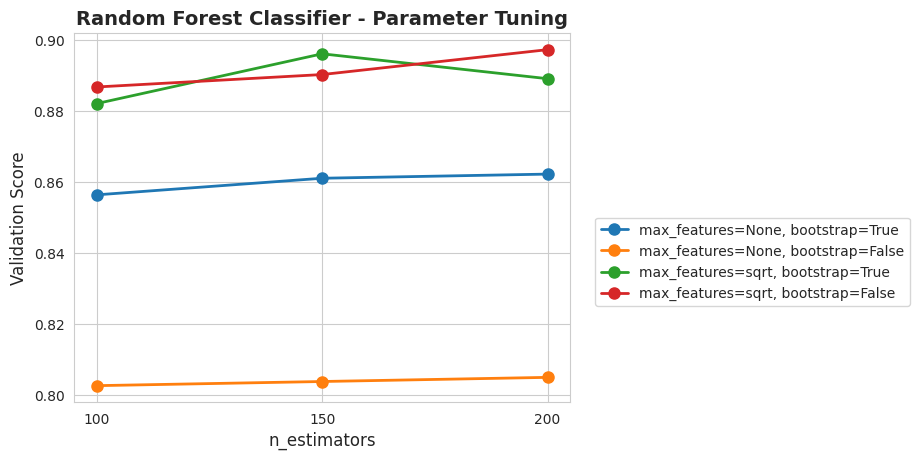

In [79]:
# PLOT THE RESULTS

results = np.array(results)

fig, ax = plt.subplots()

for max_features_val in max_features_options:
    for bootstrap_val in bootstrap_options:

        filtered_results = results[(results[:, 1] == max_features_val) & (results[:, 2] == bootstrap_val)]
        ax.plot(filtered_results[:, 0], filtered_results[:, 3], label=f"max_features={max_features_val}, bootstrap={bootstrap_val}",
            marker='o', markersize=8, linewidth=2)

ax.set_xticks(n_estimators_options)
ax.set_xlabel("n_estimators", fontsize=12)
ax.set_ylabel("Validation Score", fontsize=12)
ax.set_title("Random Forest Classifier - Parameter Tuning", fontsize=14, fontweight='bold')

ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.)
plt.show()

Using
- `max_features`: sqrt consistently yields better validation scores than max_features: None.
- Models with `bootstrap`: False generally outperform those with bootstrap: True.
- Increasing `n_estimators` (100, 150, 200) shows minor or no consistent improvement in validation scores.

The configuration I will be chosing is the following:
- n_estimators: 150
- max_features: sqrt
- bootstrap: True


When `bootstrap` is set to True sampling with replacement is used, which helps introduce randomness and diversity in the individual trees, reducing variance and improving the model's ability to generalise. However, in this case, the difference between the best model's accuracy with `bootstrap`= True is not too different from the one obtained with `bootstrap` = False.

In [100]:
best_rf_clf = ensemble.RandomForestClassifier(n_estimators=150, max_features="sqrt", bootstrap=True)
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [101]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_rf_clf, X = X_val, y_true = y_val)

Sensitivity: 0.9302
Specificity: 0.8709
Misclassification Rate: 0.0993
Accuracy Rate: 0.9007


#### Test the best model
I will now use the best model on the test dataset.

In [109]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_rf_clf, X = X_test, y_true = y_test)

models_comparison_df_rf = pd.DataFrame({
    'model': ['Random Forest'],
    'model_name': ['best_rf_clf'],
    'sensitivity': [sensitivity],
    'specificity': [specificity],
    'misclassification_rate': [misclassification_rate],
    'accuracy_rate': [accuracy_rate]
})


models_comparison_df = pd.concat([models_comparison_df, models_comparison_df_rf], ignore_index=True)

models_comparison_df


Sensitivity: 0.8951
Specificity: 0.8235
Misclassification Rate: 0.1390
Accuracy Rate: 0.8610


,model,model_name,sensitivity,specificity,misclassification_rate,accuracy_rate
0,Decision Tree,best_clf,0.884521,0.788419,0.165888,0.834112
1,Random Forest,best_rf_clf,0.895089,0.823529,0.139019,0.860981


#### FEATURE SELECTION

Feature selection can help us understand our model and the outputs it gives us, as well as remove any irrelevant predictors.

To identify the most important features in this Random Forest model, we can use two different methods:
- impurity-based feature importances (using the `.feature_importances_` function to get the inbuilt impurity metric measure. Then use the `.argsort()`
function to sort the resulting feature importances)
- permutation importances (using the `permutation_importance` function, and then use the `.argsort()` function as above).

We will be looking at feature selection for the best model (best_rf_clf).

**Impurity-based feature importances**

In [ ]:
feature_importances = best_rf_clf.feature_importances_
sorted_idx = feature_importances.argsort()


# Display the sorted feature importances ----

# remove the first column [output]
feature_names = df_analysis.columns[1:]
print(feature_names)

Index(['Days_of_Diff_PrevDis', 'los_days', 'Prev_los_days', 'n_thvis_new',
       'Prev_n_thvis', 'age', 'has_same_admit_cons', 'has_same_attend_cons',
       'time_prev_disch', 'time_new_adm',
       ...
       'dow_new_adm_Sun', 'dow_new_adm_Thu', 'dow_new_adm_Tue',
       'dow_new_adm_Wed', 'dow_prev_disch_Mon', 'dow_prev_disch_Sat',
       'dow_prev_disch_Sun', 'dow_prev_disch_Thu', 'dow_prev_disch_Tue',
       'dow_prev_disch_Wed'],
      dtype='object', length=415)


In [ ]:
df_features = pd.DataFrame({
    'feature_importances': feature_importances,
    'feature_names': feature_names})

df_features = df_features.sort_values(by = 'feature_importances', ascending = False)
df_features

,feature_importances,feature_names
1,0.089775,los_days
9,0.088430,time_new_adm
2,0.080892,Prev_los_days
206,0.061547,AdmissionPriority_Elective
0,0.039223,Days_of_Diff_PrevDis
...,...,...
280,0.000000,Prev_LocationID_bf758f901a523cfd07c881692d7bc966
134,0.000000,InpatientServiceID_DERMED
132,0.000000,InpatientServiceID_DENMED
120,0.000000,InpatientServiceID_BRACMED


The higher the importance score, the more influential the feature is in making predictions.

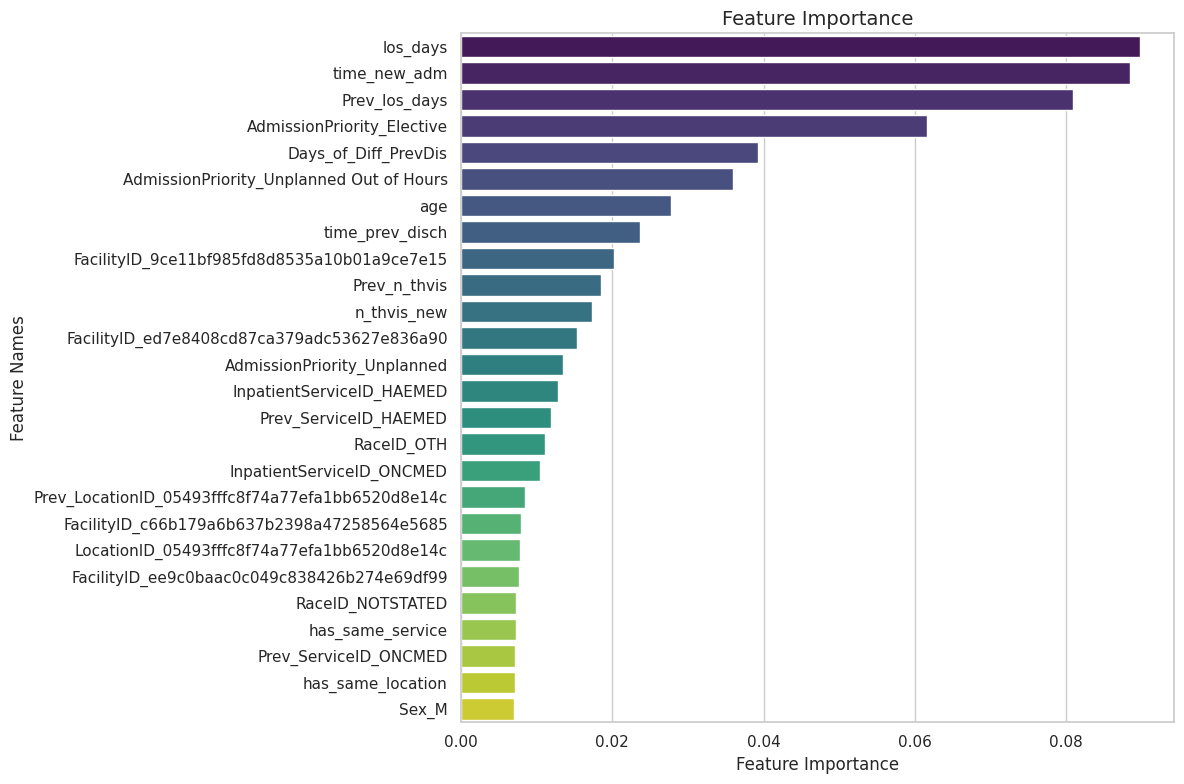

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.barplot(x="feature_importances", y="feature_names", data=df_features[0:26], hue="feature_names", dodge=False, legend=False, palette="viridis")

plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature Names", fontsize=12)
plt.title("Feature Importance", fontsize=14)


plt.tight_layout()


plt.show()

One of the downsides of the inbuilt impurity metric is that it can only be applied to training data. This doesn't give us any indication of which features will be the most important on unseen data.

Instead, we can use the permutation importance to measure the feature importances on both the training and validation sets.

**Permutation Importance**

Permutation importance is another method to assess feature importance, where the model is evaluated on the data with features randomly shuffled. The decrease in model performance after shuffling gives an indication of how important that feature was.

In [ ]:
# permutation method on both training set

result_train = permutation_importance(estimator= best_rf_clf, X = X_train, y = y_train, n_repeats = 10, random_state = 1, n_jobs = 2)
sorted_idx = result_train.importances_mean.argsort()

print(sorted_idx)

[207 282 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266
 265 264 263 262 283 284 285 286 308 307 306 305 304 303 302 301 300 299
 261 298 296 295 294 293 292 291 290 289 288 287 297 260 259 258 231 230
 229 228 227 226 225 224 223 222 232 221 219 218 217 216 215 214 213 212
 211 209 220 309 233 235 257 256 255 254 253 252 251 250 249 248 234 247
 245 244 243 242 241 240 239 238 237 236 246 310 311 312 386 385 384 383
 382 381 380 379 378 377 387 376 374 373 372 371 370 369 368 367 366 365
 375 364 388 390 412 411 410 409 408 407 406 405 404 403 389 402 400 399
 398 397 396 395 394 393 392 391 401 208 363 361 334 333 332 331 330 329
 328 327 326 325 335 324 322 321 320 319 318 317 316 315 314 313 323 362
 336 338 360 359 358 357 356 355 354 353 352 351 337 350 348 347 346 345
 344 343 342 341 340 339 349 413 414 205  77  76  75  74  73  72  71  70
  69  68  67  66  65  64  63  62  61  60  59  58  57  78  56  79  81 102
 101 100  99  98  97  96  95  94  93  92  91  90  8

In [ ]:
sorted_idx_top20 = sorted_idx[-20:]
print(sorted_idx_top20)

[143 146 141 133 134 142 136 135 138 139 140 137   0 210  23   4 206   1
   2   9]


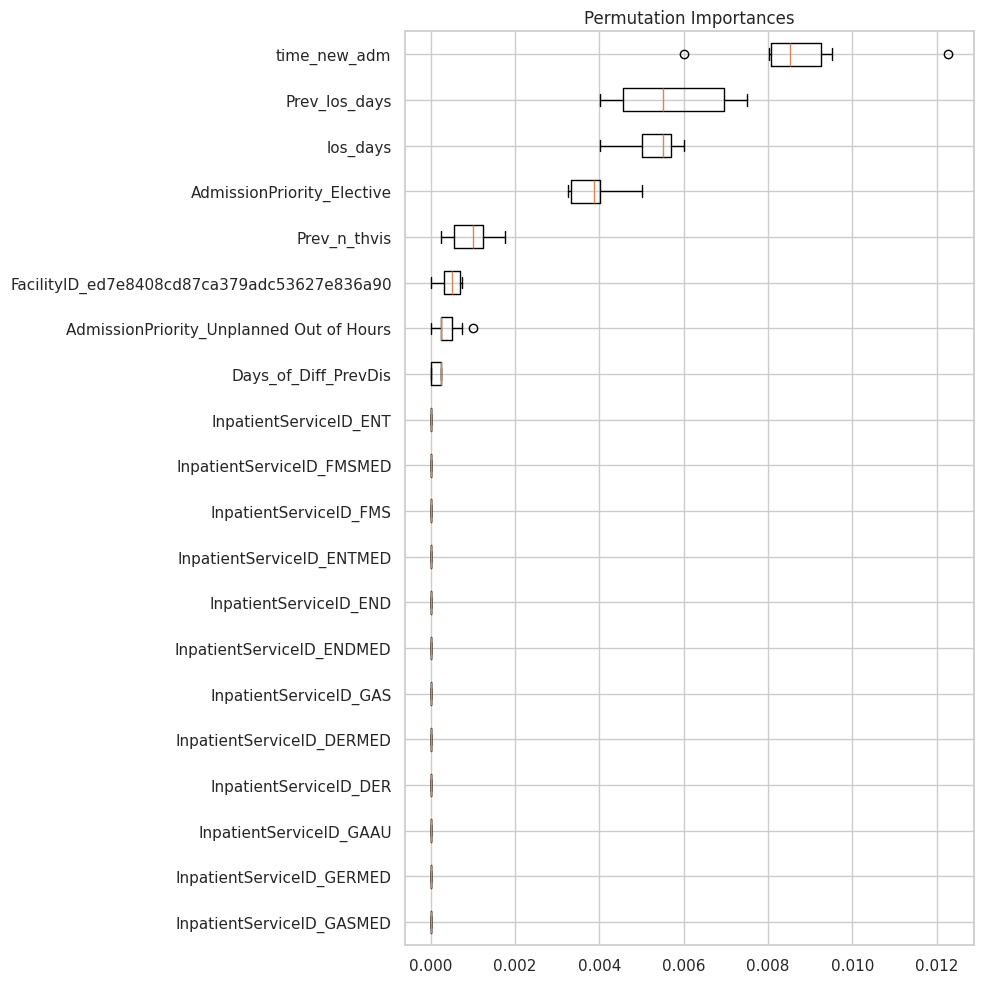

In [ ]:
def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx_top20].T, vert=False, labels=feature_names[sorted_idx_top20]
    )
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()

plot_perm_importance(result_train, sorted_idx_top20, feature_names)

Let's have a look at the permutation importance by using the validation dataset.

[ 11 152 347 359 283  16 232 185   0  12  23  18  20 210   4   3   2   9
   1 206]


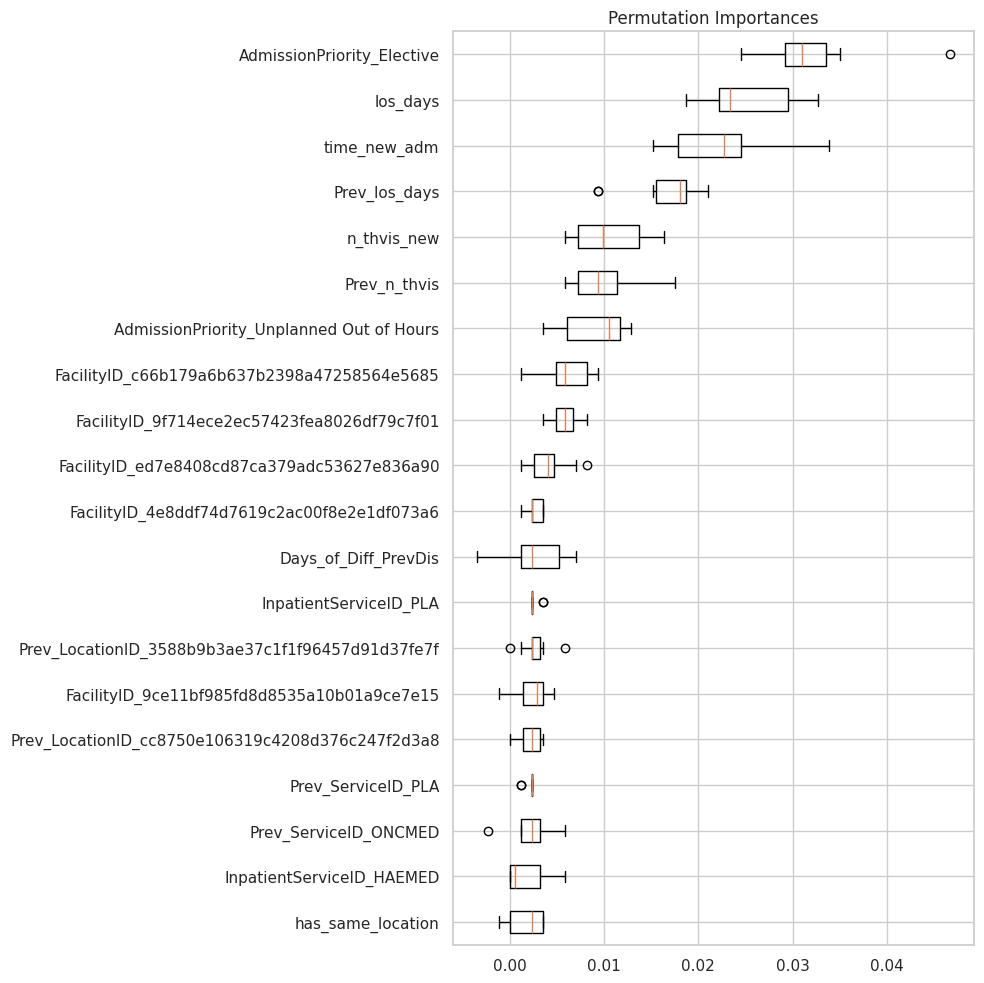

In [ ]:
result_val = permutation_importance(estimator= best_rf_clf, X = X_val, y = y_val, n_repeats = 10, random_state = 1, n_jobs = 2)
sorted_idx = result_val.importances_mean.argsort()

sorted_idx_top20 = sorted_idx[-20:]
print(sorted_idx_top20)

plot_perm_importance(result_val, sorted_idx_top20, feature_names)

Finally, let's apply it to the test dataset.

[409 209 350 152  18  72 324  24 325   4  11   0 210  16   3  23   2   1
   9 206]


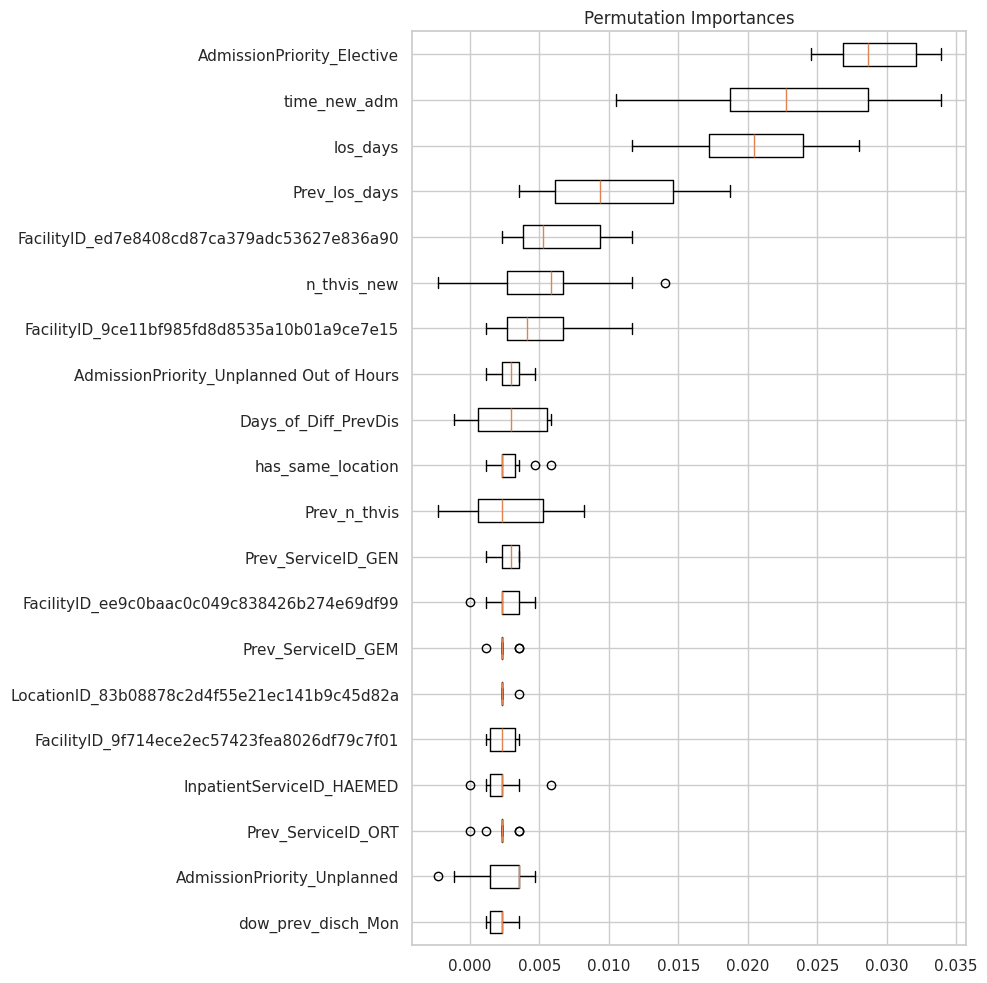

In [ ]:
result_test = permutation_importance(estimator= best_rf_clf, X = X_test, y = y_test, n_repeats = 10, random_state = 1, n_jobs = 2)
sorted_idx = result_test.importances_mean.argsort()

sorted_idx_top20 = sorted_idx[-20:]
print(sorted_idx_top20)

plot_perm_importance(result_test, sorted_idx_top20, feature_names)

Impurity-based importances (using `.feature_importances_`) are faster to compute and are computed directly from the model itself. They tell us how much each feature contributes to reducing impurity (i.e., making better splits).
`Permutation importances` are a more model-agnostic approach and are often more reliable because they measure the actual impact on model performance.

On the back of the results above, it seems that both the impurity-based feature importance (via `rf_clf.feature_importances_`) and permutation importances methods are in agreement that Length of stays and Previous Lenght of stays, time of the new admission, elective admissions, and number of theatre visits  are the most important features in the model. These features have the greatest influence on the model's predictions, suggesting that they are key indicators of unplanned readmissions.

This information can be leveraged in a future iteration of this project to create a more proactive model. By identifying these high-risk factors, clinical staff could be better equipped to manage these patients before discharge or during the critical period shortly after discharge. For example, the model could flag patients who exhibit these high-risk features, prompting further interventions or more intensive follow-up care to prevent unplanned readmissions.

Ultimately, this would help enhance patient care and improve hospital resource utilisation by identifying at-risk patients earlier, thus preventing avoidable readmissions and improving overall patient outcomes.

### LOGISTIC REGRESSION


Logistic regression is a simple, yet powerful, linear model used for binary classification tasks, predicting the probability of an event occurring based on input features. In healthcare problems, this method is often favoured over fancier models like Neural Networks because of its explainability and simplicity, hence it should not be overlooked.

Key Hyperparameters of Logistic Regression:
- C: Regularisation strength; smaller values specify stronger regularisation.
- penalty: The type of regularisation to apply ('l2', 'l1', 'elasticnet', or None).
- solver: Algorithm used for optimisation ('liblinear', 'saga', 'newton-cg', 'lbfgs', 'saga').
- max_iter: Maximum number of iterations taken for the solver to converge.
- fit_intercept: Whether to include an intercept in the model (True or False).
- class_weight: Weights associated with classes for imbalanced datasets (either balanced or a dictionary of class weights).
- tol: Tolerance for stopping criteria.
- multi_class: Strategy for multi-class classification ('ovr', 'multinomial').
- random_state: Seed used by the random number generator for reproducibility.
- intercept_scaling: Scaling of the intercept term (used only when solver='liblinear').

I'll prepare the dataset for this model. In this case I need to run the following pre-processing steps:
- transform booleans into integers (0 or 1)
- use one-hot encoding for categorical variables
- apply scaling for numerical variables.


In [35]:
print(df_clean.columns)

Index(['f_TF', 'FacilityID', 'LocationID', 'InpatientServiceID',
       'AdmissionPriority', 'Days_of_Diff_PrevDis', 'Prev_LocationID',
       'Prev_ServiceID', 'Sex', 'FinancialClassID', 'RaceID', 'los_days',
       'Prev_los_days', 'n_thvis_new', 'Prev_n_thvis', 'age',
       'has_same_admit_cons', 'has_same_attend_cons', 'dow_prev_disch',
       'time_prev_disch', 'dow_new_adm', 'time_new_adm', 'has_same_service',
       'has_same_location'],
      dtype='object')


In [36]:
df_lr = pd.get_dummies(df_clean, columns=['FacilityID', 'LocationID', 'InpatientServiceID',
                                          'AdmissionPriority', 'Prev_LocationID', 'Prev_ServiceID',
                                          'FinancialClassID', 'RaceID'], drop_first=True)

In [37]:
df_lr.loc[:, 'Sex'] = df_lr['Sex'].replace({'M': 1, 'F': 0})
df_lr.loc[:, 'dow_prev_disch'] = df_lr['dow_prev_disch'].replace({'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7})
df_lr.loc[:, 'dow_new_adm'] = df_lr['dow_new_adm'].replace({'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7})


<ipython-input-37-aadd97541771>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_lr.loc[:, 'Sex'] = df_lr['Sex'].replace({'M': 1, 'F': 0})
<ipython-input-37-aadd97541771>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_lr.loc[:, 'dow_prev_disch'] = df_lr['dow_prev_disch'].replace({'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7})
<ipython-input-37-aadd97541771>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitl

In [38]:
# Identify boolean columns
bool_cols = df_lr.select_dtypes(include=['bool']).columns

# Convert boolean columns to 0-1 integers
df_lr[bool_cols] = df_lr[bool_cols].astype(int)

In [39]:
outputs = ['f_TF']
inputs = [col for col in df_lr.columns if col not in outputs]

X = df_lr[inputs]
Y = df_lr[outputs].to_numpy().reshape(-1)

Scaling data before fitting a logistic regression model is important for the following reasons:

- Ensures all features are on similar scales, avoiding issues caused by varying magnitudes in the model.
- Facilitates smoother convergence of numerical optimisation algorithms like gradient descent by harmonising gradient magnitudes across features.
- Prevents larger-magnitude features from dominating the penalty term when using regularisation techniques (L1/L2), ensuring unbiased results.
- Allows for easier comparison of feature importance by standardising scales, ensuring coefficients reflect relative impact rather than differences in feature magnitude.

When scaling features, it is crucial to scale the training and testing data separately to prevent information leakage from the testing set into the training set. This ensures the model does not inadvertently gain access to "unknown" information from the test data during training, maintaining the integrity of the train-test split.


In [40]:
# Split into train and remaining (validation + test)
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.7, random_state=42)

# Split remaining into validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=42)  # 0.5 for equal split

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(3994, 405) (856, 405) (856, 405)
(3994,) (856,) (856,)


In [41]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)


scaler = StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)


scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [42]:
# Create the model and train it using the training dataset
lr_model = LogisticRegression(penalty = None)
lr_model.fit(X_train, Y_train)

# Evaluate the model's performance on the validation set
y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)

cm_train = confusion_matrix(y_true = Y_train, y_pred = y_pred_train)
cm_val = confusion_matrix(y_true = Y_val, y_pred = y_pred_val)

accuracy_train = accuracy_score(y_true = Y_train, y_pred = y_pred_train)

accuracy_val = accuracy_score(y_true = Y_val, y_pred = y_pred_val)

print("Training Accuracy:", accuracy_train)
print(cm_train)

print("Validation Accuracy:", accuracy_val)
print(cm_val)

Training Accuracy: 0.8800701051577366
[[1696  282]
 [ 197 1819]]
Validation Accuracy: 0.8364485981308412
[[357  80]
 [ 60 359]]


The accuracy of the logistic regression model is comparable to the one from the tree based models. I will now perform hyperparameter tuning to refine the model and see if I can improve accuracy.


**Tuning the regularisation and penalty parameters**

In [43]:
# Define parameter grid
step_c = 100
c_values = np.linspace(10e-5, 10e-1, step_c)
penalty_types = ['l1', 'l2']

results = []

# Loop over parameters
for penalty in penalty_types:
    for c in c_values:
        lr_model = LogisticRegression(penalty=penalty, C=c, solver='liblinear' if penalty == 'l1' else 'lbfgs') # change solver based on the chosen penalty
        lr_model.fit(X_train, Y_train)

        y_pred_val = lr_model.predict(X_val)
        accuracy = accuracy_score(y_true=Y_val, y_pred=y_pred_val)
        results.append([c, penalty, accuracy])

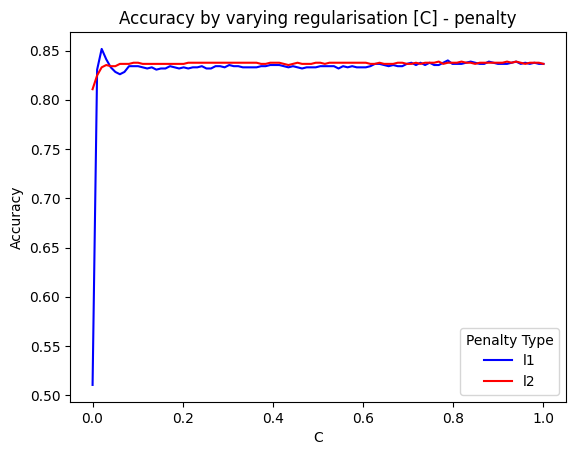

In [44]:
results_df = pd.DataFrame(results, columns=['c', 'penalty', 'accuracy_score'])

colors = {'l1': 'blue', 'l2': 'red'}

for penalty_type in results_df['penalty'].unique():
    subset = results_df[results_df['penalty'] == penalty_type]
    plt.plot(subset['c'], subset['accuracy_score'], label=penalty_type, color=colors[penalty_type])

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy by varying regularisation [C] - penalty')
plt.legend(title='Penalty Type')
plt.show()

From the plot above, it seems that the accuracy is oscillating for values of c <0.1, and then it stabilises.

l2 seems to be consistently above l1 in terms of accuracy, but they are not too different.

I am going to pick the arbitrary point of c=0.2, and penalty = l2.

In [45]:
results_df

,c,penalty,accuracy_score
0,0.0001,l1,0.510514
1,0.0102,l1,0.830607
2,0.0203,l1,0.851636
3,0.0304,l1,0.841121
4,0.0405,l1,0.832944
...,...,...,...
195,0.9596,l2,0.836449
196,0.9697,l2,0.837617
197,0.9798,l2,0.837617
198,0.9899,l2,0.837617


In [46]:
lr_best_accuracy = results_df[(results_df['c'] == 0.20209999999999997) & (results_df['penalty'] == 'l2')]

print("Best Logistic Regression model:\n", lr_best_accuracy)
print("\nLogistic Regression model's accuracy with default parameters:\n", accuracy_val)

Best Logistic Regression model:
           c penalty  accuracy_score
120  0.2021      l2        0.836449

Logistic Regression model's accuracy with default parameters:
 0.8364485981308412


I'll now save my best Logistic Regression model into the object best_lr.

In [47]:
best_lr = LogisticRegression(penalty = 'l2', C = 0.20209999999999997, solver='lbfgs')
best_lr.fit(X_train, Y_train)

LogisticRegression(C=0.20209999999999997)

Logistic regression models typically predict probabilities for binary outcomes (e.g., P(y=0) and P(y=1)), and, by default, predictions use a threshold of 0.5 (probabilities ≥ 0.5 are classified as 1, and probabilities < 0.5 are classified as 0).

It is possible, however, to customise the threshold for converting probabilities into binary predictions, and allow the user to adjust sensitivity and specificity, thus balancing priorities.

The function below, `predict_prob_threshold`, customises these predictions based on a user-defined probability threshold (prob_threshold).
I will use this function over the [0, 1] probability threshold space, and understand whether it is worth changing the threshold from 0.5 to a customised one.

In [ ]:
def predict_prob_threshold(lr_model, X, prob_threshold):

    # return the probabilities of one of the 2 binary output: predict_proba returns 2 columns, one with the P of y = 0 and one for x = 1
    arr_probab = lr_model.predict_proba(X)[:, 1]

    # return the array with the predictions as 0 and 1, based on the threshold
    arr_pred = (arr_probab >= prob_threshold).astype(int)

    return(arr_pred)


In [ ]:
thr_step = 200
thresholds_range = np.linspace(0, 1, thr_step)

TOT_POS = np.sum(Y_val)
TOT_NEG = len(Y_val) - TOT_POS

FNR = []
FPR = []

for thr in thresholds_range:
    y_pred_val = predict_prob_threshold(lr_model = best_lr, X = X_val, prob_threshold = thr)
    cm = confusion_matrix(Y_val, y_pred_val)


    fn = cm[1, 0] / TOT_POS
    fp = cm[0, 1] / TOT_NEG

    FNR.append(fn)
    FPR.append(fp)

Text(0.5, 1.0, 'Models performance at varying level of probability threshold')

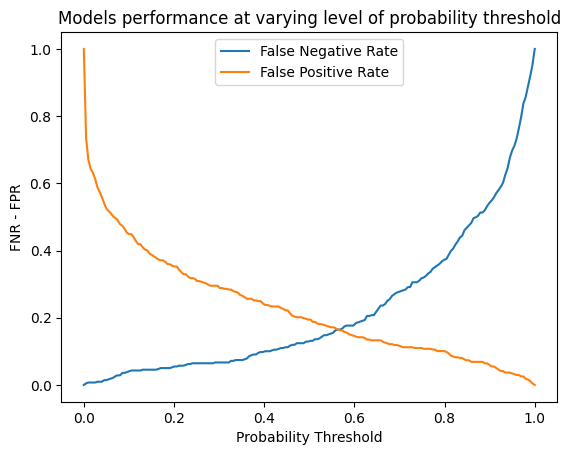

In [ ]:
# PLOT FNR / FPR with different thresholds [on validation data]

plt.plot(thresholds_range, FNR, label = 'False Negative Rate')
plt.plot(thresholds_range, FPR, label = 'False Positive Rate')
plt.legend()
plt.xlabel('Probability Threshold')
plt.ylabel('FNR - FPR')
plt.title('Model''s performance at varying level of probability threshold')

FNR: fraction of missed positive cases out of all the actual positives = FN / (FN + TP)

FPR: proportion of actual negative cases that are incorrectly predicted as positive by a model.

**CONSIDERATIONS**

To decide on the probability threshold to use, we need to consider how this model is going to be used.
Ideally we want a low False Positive Rate (FPR) and a low False Negative Rate (FNR). Looking at the plot above, a probability threshold of 0.5 would return a 10% FNR and 18% FPR.

I believe that FNR (False Negative Rate) is the metric to minimise, as it directly relates to missing unplanned readmissions, which could, in this case, affect regulatory compliance. However, the trade-off should be balanced against operational efficiency, especially if reducing FNR significantly increases FPR. That said, this is one of decisions that needs to be carefully taken with the stakeholders, so if the want the model to strongly avoid false negatives, we would use a probability threshold lower than 0.5 as per plot above, to the expense of FPR.

Since the plot above is in agreement with the strategy of minimising FNR, I will keep the probability threshold for the classification results to 0.5.

In [48]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_lr, X = X_val, y_true = Y_val)


Sensitivity: 0.8687
Specificity: 0.8055
Misclassification Rate: 0.1636
Accuracy Rate: 0.8364


#### Test the best model
I will now use the best model on the test dataset.

In [ ]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_lr, X = X_test, y_true = Y_test)

models_comparison_df_lr = pd.DataFrame({
    'model': ['Logistic Regression'],
    'model_name': ['best_lr'],
    'sensitivity': [sensitivity],
    'specificity': [specificity],
    'misclassification_rate': [misclassification_rate],
    'accuracy_rate': [accuracy_rate]
})


models_comparison_df = pd.concat([models_comparison_df, models_comparison_df_lr], ignore_index=True)


In [124]:
models_comparison_df

,model,model_name,sensitivity,specificity,misclassification_rate,accuracy_rate
0,Decision Tree,best_clf,0.884521,0.788419,0.165888,0.834112
1,Random Forest,best_rf_clf,0.895089,0.823529,0.139019,0.860981
2,Logistic Regression,best_lr,0.873206,0.815068,0.156542,0.843458


#### PREDICTION PROBABILITIES

One of the advantages of using a Logistic Regression model, is that I can look at the probability with which every individual decision was taken for each of the re-admissions.

I could then use this information in 2 ways:
- understand which cases my model is more uncertain about, and try to optimise the model for those
- give this probability to the user, that could focus on the classification or review only of those 'edge-cases' (e.g - where a decision was made only with a probability score of 51-70%).

In [ ]:
def predict_with_probabilities(lr_model, X):
    """
    Returns the predicted class and associated probability scores for a logistic regression model.

    Parameters:
    - lr_model: A trained LogisticRegression model.
    - X: Feature dataset for which predictions and probabilities are to be computed.

    Returns:
    - A DataFrame with predicted classes and their associated probabilities for both classes.
    """

    # Get probabilities for both classes
    probabilities = lr_model.predict_proba(X)

    # Get the predicted class (0 or 1)
    predictions = lr_model.predict(X)

    # Combine predictions and probabilities into a DataFrame
    results = pd.DataFrame({
        'predicted_class': predictions,
        'probability_class_0': probabilities[:, 0],  # Probabilities for class 0
        'probability_class_1': probabilities[:, 1]   # Probabilities for class 1
    })

    return results

In [ ]:
lr_results = predict_with_probabilities(best_lr, X_val)

lr_results['to_review'] = (
    (lr_results['probability_class_0'] < 0.7) & (lr_results['predicted_class'] == 0) |
    (lr_results['probability_class_1'] < 0.7) & (lr_results['predicted_class'] == 1)
)

The table below will show all those cases that have been identified as edge-cases and therefore might need manual review.

In [ ]:
lr_results[lr_results['to_review']]

,predicted_class,probability_class_0,probability_class_1,to_review
0,1,0.414396,0.585604,True
9,1,0.392512,0.607488,True
19,1,0.327903,0.672097,True
22,0,0.543004,0.456996,True
24,0,0.582689,0.417311,True
...,...,...,...,...
837,1,0.321911,0.678089,True
841,1,0.453480,0.546520,True
843,1,0.377840,0.622160,True
852,0,0.653802,0.346198,True


### KNN

K-Nearest Neighbors (KNN) is a simple, non-parametric, instance-based learning algorithm used for classification and regression, where predictions are made based on the majority class or average value of the k-nearest data points in feature space.
The hyperparameters of a KNN model are listed below:

1. **`n_neighbors`**: Number of nearest neighbors to consider (default: 5).
2. **`weights`**: Weighting function used in prediction (`'uniform'` for equal weights or `'distance'` for weight inversely proportional to distance).
3. **`algorithm`**: Algorithm used to compute nearest neighbors (`'auto'`, `'ball_tree'`, `'kd_tree'`, `'brute'`).
4. **`leaf_size`**: Leaf size passed to BallTree or KDTree (affects speed and memory).
5. **`p`**: Power parameter for the Minkowski distance metric (e.g., `p=2` is equivalent to Euclidean distance).
6. **`metric`**: Distance metric to use (e.g., `'minkowski'`, `'euclidean'`, `'manhattan'`, or a custom callable).
7. **`metric_params`**: Additional keyword arguments for the distance metric function.
8. **`n_jobs`**: Number of parallel jobs for neighbors search (-1 means using all processors).


KNN models accepts numerical input. Therefore we will habe to encode the categorical data. KNN's inputs should not contain missing values, but this is not a problem in our case, as we have already taken care of those.
In this case I can use the same dataset used for the logistic regression model. They also have already been scaled.

In [50]:
neigh = KNeighborsClassifier(n_neighbors = 1) #train a KNN with K = 1
neigh.fit(X_train, Y_train) #fit it to our training set

KNeighborsClassifier(n_neighbors=1)

In [51]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = neigh, X = X_val, y_true = Y_val)

Sensitivity: 0.7542
Specificity: 0.7323
Misclassification Rate: 0.2570
Accuracy Rate: 0.7430


In [52]:
Y_pred = neigh.predict(X_test) #predict the test set

cm_knn = confusion_matrix(Y_test, Y_pred) #first row of the confusion matrix will be the true "No"s and second row "Yes"s
cm_knn

array([[324, 114],
       [ 94, 324]])

In [53]:
k_values = [1, 3, 5, 7, 9, 11]
list_knn = []


for K in k_values:
   neigh = KNeighborsClassifier(n_neighbors = K)
   neigh.fit(X_train, Y_train)

   sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = neigh, X = X_val, y_true = Y_val)
   k_list = [K, sensitivity, specificity, misclassification_rate, accuracy_rate]
   list_knn.append(k_list)


df_knn = pd.DataFrame(list_knn, columns = ['K', 'sensitivity', 'specificity', 'misclassification_rate', 'accuracy_rate'])
df_knn


Sensitivity: 0.7542
Specificity: 0.7323
Misclassification Rate: 0.2570
Accuracy Rate: 0.7430
Sensitivity: 0.8282
Specificity: 0.7300
Misclassification Rate: 0.2220
Accuracy Rate: 0.7780
Sensitivity: 0.8425
Specificity: 0.7254
Misclassification Rate: 0.2173
Accuracy Rate: 0.7827
Sensitivity: 0.8473
Specificity: 0.7048
Misclassification Rate: 0.2255
Accuracy Rate: 0.7745
Sensitivity: 0.8687
Specificity: 0.6934
Misclassification Rate: 0.2208
Accuracy Rate: 0.7792
Sensitivity: 0.8807
Specificity: 0.6842
Misclassification Rate: 0.2196
Accuracy Rate: 0.7804


,K,sensitivity,specificity,misclassification_rate,accuracy_rate
0,1,0.754177,0.732265,0.257009,0.742991
1,3,0.828162,0.729977,0.221963,0.778037
2,5,0.842482,0.725400,0.217290,0.782710
3,7,0.847255,0.704805,0.225467,0.774533
4,9,0.868735,0.693364,0.220794,0.779206
5,11,0.880668,0.684211,0.219626,0.780374


In [54]:
# Compare your results with the classifier which always says False.
Y_pred_no = np.full(Y_pred.shape[0], False)
cm_no = confusion_matrix(Y_test, Y_pred_no)

nr_pos_no = np.sum(Y_pred_no == True)
true_neg_no = cm_no[0][0]
true_pos_no = cm_no[1][1]
false_pos_no = cm_no[0][1]
false_neg_no = cm_no[1][0]
misclassification_rate_no = (false_pos_no + false_neg_no)/np.sum(cm_no)
sensitivity_no = true_pos_no / (true_pos_no + false_neg_no) #or recall (out of positives what percent can we guess)


print("Misclassification Rate:", misclassification_rate_no)
print("Sensitivity:", sensitivity_no)

Misclassification Rate: 0.4883177570093458
Sensitivity: 0.0


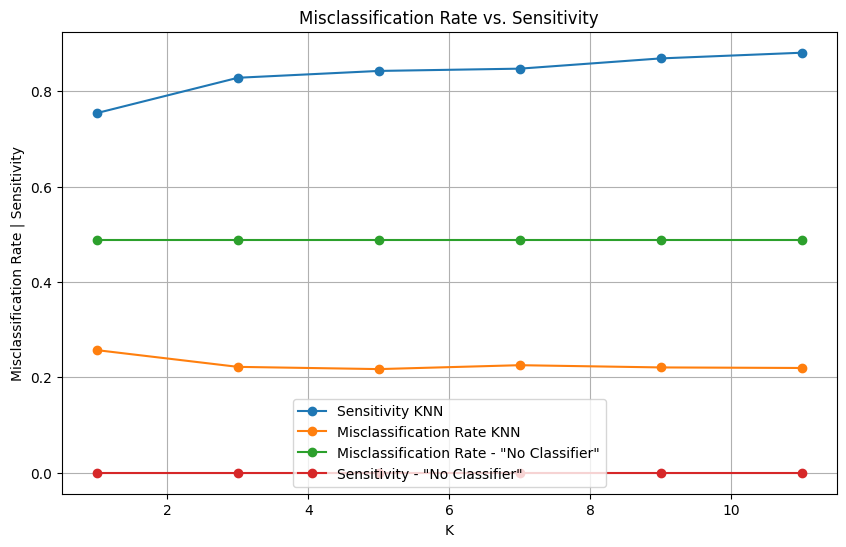

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df_knn['K'], df_knn['sensitivity'], marker='o', label = 'Sensitivity KNN')
plt.plot(df_knn['K'], df_knn['misclassification_rate'], marker='o', label = 'Misclassification Rate KNN')

plt.plot(k_values, np.full(6, misclassification_rate_no), marker='o', label = 'Misclassification Rate - "No Classifier"')
plt.plot(k_values, np.full(6, sensitivity_no), marker='o', label = 'Sensitivity - "No Classifier"')

plt.xlabel('K')
plt.ylabel('Misclassification Rate | Sensitivity')
plt.title('Misclassification Rate vs. Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

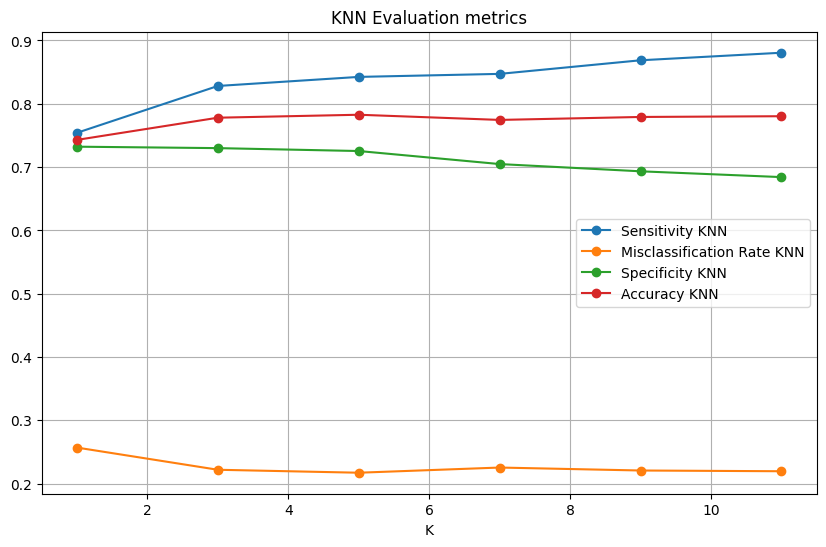

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df_knn['K'], df_knn['sensitivity'], marker='o', label = 'Sensitivity KNN')
plt.plot(df_knn['K'], df_knn['misclassification_rate'], marker='o', label = 'Misclassification Rate KNN')
plt.plot(df_knn['K'], df_knn['specificity'], marker='o', label = 'Specificity KNN')
plt.plot(df_knn['K'], df_knn['accuracy_rate'], marker='o', label = 'Accuracy KNN')

plt.xlabel('K')
plt.ylabel('')
plt.title('KNN Evaluation metrics')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
df_knn[df_knn['K'] == 7]

,K,sensitivity,specificity,misclassification_rate,accuracy_rate
3,7,0.847255,0.704805,0.225467,0.774533


On the back of what has been discussed in the results section of the Logistic Regression paragraph, we prefer to have a lower False Negative Rate than a False Positive Rate. This means we give more importance to Sensitivity than the Specificity. Sensitivity (or Recall) measures the proportion of actual positive correctly identified by the model. To achieve higher sensitivity values, we are willing to tolerate a potential increase in False Positives (FP), which may reduce Specificity. This tradeoff is common in applications like the present one, where missing a positive case (high FNR) is more costly than having false alarms (low Specificity).

By evaluating the results above, therefore, the best K for the model seems to be k = 7. The highest sensitivity is achieved at k = 11, but being the difference minimal, by picking k = 7 we will have better values for specificity and misclassification rate (proportion of all predictions made by a model that are incorrect).

In [58]:
best_knn = KNeighborsClassifier(n_neighbors = 7)
best_knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=7)

#### Test the best model
I will now use the best model on the test dataset.

In [ ]:
sensitivity, specificity, misclassification_rate, accuracy_rate = calculate_classification_metrics(model = best_knn, X = X_test, y_true = Y_test)

models_comparison_df_knn = pd.DataFrame({
    'model': ['KNN'],
    'model_name': ['best_knn'],
    'sensitivity': [sensitivity],
    'specificity': [specificity],
    'misclassification_rate': [misclassification_rate],
    'accuracy_rate': [accuracy_rate]
})


models_comparison_df = pd.concat([models_comparison_df, models_comparison_df_knn], ignore_index=True)


In [120]:
models_comparison_df

,model,model_name,sensitivity,specificity,misclassification_rate,accuracy_rate
0,Decision Tree,best_clf,0.884521,0.788419,0.165888,0.834112
1,Random Forest,best_rf_clf,0.895089,0.823529,0.139019,0.860981
2,Logistic Regression,best_lr,0.873206,0.815068,0.156542,0.843458
3,KNN,best_knn,0.827751,0.712329,0.231308,0.768692


## CHOOSING THE BEST MODEL

The metrics that I've monitored whilst developing the different models are the following ones:
- sensitivity
- specificity
- misclassification rate
- accuracy rate

However, the ones that I am most interested in, as already discussed before, are 'Sensitivity' and 'Misclassification Rate'. Thus, I will use these two to identify the best performing algorithm.

Below, I've reported a table and a plot to faciltate the comparison side by side.

In [121]:
models_comparison_df

,model,model_name,sensitivity,specificity,misclassification_rate,accuracy_rate
0,Decision Tree,best_clf,0.884521,0.788419,0.165888,0.834112
1,Random Forest,best_rf_clf,0.895089,0.823529,0.139019,0.860981
2,Logistic Regression,best_lr,0.873206,0.815068,0.156542,0.843458
3,KNN,best_knn,0.827751,0.712329,0.231308,0.768692


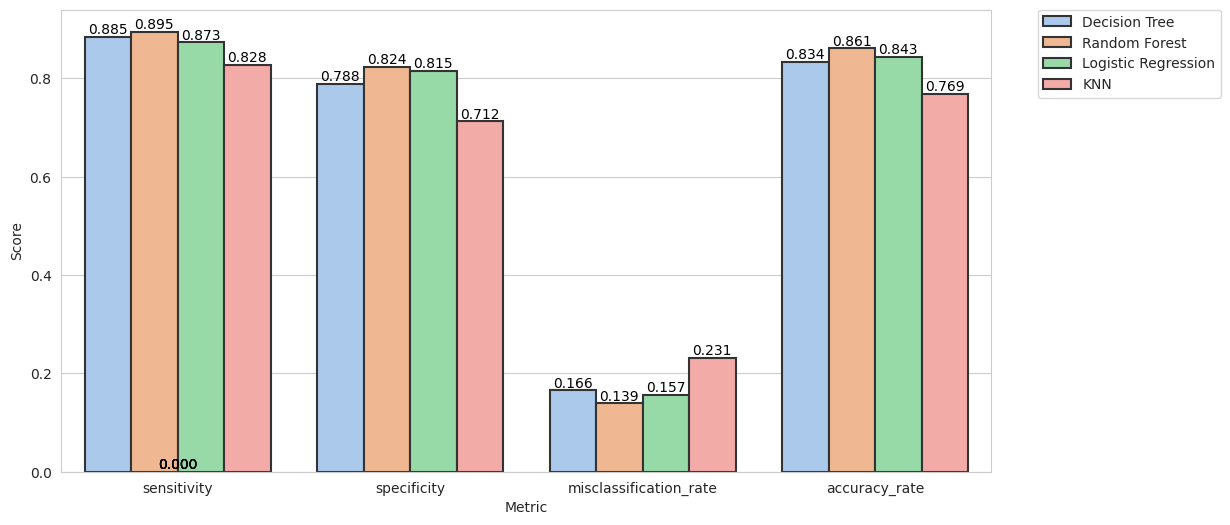

In [122]:
# Melting the DataFrame for plotting
models_comparison_df_melted = models_comparison_df.melt(
    id_vars='model',
    value_vars=['sensitivity', 'specificity', 'misclassification_rate', 'accuracy_rate'],
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='model',
    data=models_comparison_df_melted,
    palette="pastel",
    edgecolor=".2",
    linewidth=1.5
)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        fontsize=10,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Move legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Random Forest** (best_rf_clf) has the highest sensitivity of 0.895 indicating it is the best at detecting positive cases. This model balances well with a high specificity (0.824) and a relatively low misclassification rate (0.139), leading to a high accuracy rate of 0.861.

**Decision Tree** (clf) achieves a sensitivity of 0.885, which is slightly lower than Random Forest but still strong. Its specificity (0.788) and accuracy (0.834) are lower than those of Random Forest, but it maintains a reasonable balance.

**Logistic Regression** (best_lr) has a sensitivity of 0.873, placing it third in terms of positive case detection. Its specificity (0.815) and accuracy (0.843) are comparable to the Decision Tree but slightly behind the Random Forest.

**KNN** (best_knn) shows the lowest sensitivity of 0.828, indicating it struggles the most with identifying positive cases compared to the other models. Its specificity (0.712) and accuracy (0.769) are also the lowest
among all models.


## DISCUSSION


For healthcare problems, model **explainability** is critical as it influences patient care, trust, ethical decision-making, and adherence to regulatory standards. Moreover, transparent models allow clinicians and non-clinical teams to detect and rectify errors or biases, minimising risks and maintaining data integrity.
In the specific context of this project, the emphasis on transparency is tied less to patient outcomes and more to regulatory compliance: misclassification could compromise mandated reporting to regulators, and laws often require interpretable models to ensure the ethical and lawful use of data.

Of the 4 models tested for this project, the most explainable models are **Decision Trees** and **Logistic Regression**, as they make it easier to trust and understand the predictions by providing a good balance of interpretability.
- Decision trees are inherently interpretable. The tree structure clearly shows the decision paths, making it easy to understand how predictions are made. The model achieves a good sensitivity of 0.885, balancing explainability with performance.
- Logistic Regression provides a clear, linear relationship between features and predictions. Coefficients are straightforward to interpret, making it a good candidate for transparent models. Its sensitivity is 0.873, slightly lower than the Decision Tree, but still competitive.
- While Random Forest achieves the highest sensitivity (0.895), it is a complex ensemble model, making it challenging to interpret. Explaining individual predictions often requires advanced techniques like feature importance plots.
- KNN is not inherently interpretable because predictions depend on the distribution of neighbors in the feature space. It has the lowest sensitivity (0.828) among the models, making it less suitable both in terms of explainability and performance.

----

Additional considerations for selecting a model include its **deployment** into the complete classification workflow.

As detailed in the DataSheet section of the README file, the current process for classifying cases into "Planned" vs. "Unplanned" readmissions is performed manually via an App used by the governance teams. This App displays a daily refreshed worklist of cases that could qualify as unplanned readmissions based on the 31-day criteria.

The governance facilitator reviews each case and assigns a classification. At the end of each month, a meeting is held at each site to individually review all unplanned readmission cases. This serves two purposes:

- Validation: Ensuring that decisions made are accurate and aligned with the team's assessment.
- Learning: Analysing adverse events to improve processes and prevent similar occurrences in the future.


The plan is to enhance this existing App by integrating the automatic classification performed by the ML algorithm. But we should first consider the risks associated to misclassification. As it is used to make a classification once the episode of care is completed, this algorithm would not affect patient's directly (which is the highest risk when using ML in healthcare settings). Nonetheteless, in case of ML misclassification, there is the risk of incorrect reporting to regulators, which might result in non-compliance with healthcare standards. This could lead to financial penalties, legal liabilities, or loss of accreditation. At the same time, since readmission rates are often used as key metrics in performance evaluations, both for hospitals and healthcare systems, misclassification could distort these metrics, affecting institutional rankings, funding, and reputation.

If the model is frequently misclassifying cases, clinicians and governance teams may lose trust in the system, which can hinder adoption of this and future ML developments. This is particularly problematic in healthcare, where human oversight and expertise are critical.

While automated models can improve efficiency, it's important to carefully manage and mitigate the risks associated with misclassification to ensure that patient safety, regulatory compliance, and trust are maintained. An option is, depending on the algorithm chosen, to present the ML classification alongside the certainty of that classification. If we were to pick the case of Logistic Regression, this could be represented by the **probability score** associated with each classification, providing a measure of confidence in the model's decision. This additional information would help governance teams assess the reliability of the prediction and make more informed decisions during their review process. Over time, the automatic classification could be used for certain cases, where the model is highly confident in its predictions. The App could then highlight the edge cases —those where the model's confidence is lower— for review by the staff. This approach would streamline the workflow by allowing the governance teams to focus on the more ambiguous or uncertain cases while relying on the model for routine classifications.

Overall, this integration would:

- Provide full transparency to governance teams.
- Allow teams to review the automated results alongside their internal notes.
-Enable a cross-referencing process that preserves manual oversight while streamlining the workflow.


## CONCLUSION AND NEXT STEPS

Despite this project was more a proof of concept rather than a finished model, the results are already remarkable, and as per discussion above, the Logistic Regression model is probably the best choice. With small tweaking, this automatic classification could be easily deployed into the existing governance teams' workflow: by embedding the ML model into the App, the classification process can become more efficient while retaining the human-in-the-loop approach that is critical for trust, validation, and continuous learning.

However, many additional steps could be used to further improve the performance.










#### **ADDITIONAL FEATURES TO EXPLORE**

First of all, additional features could be added to the model to improve the prediciton. These are:
- Vital Signs: Include the last set of vital signs recorded before the previous discharge and the first set recorded after the new admission.
- Blood Test Results: Incorporate blood test results from both the previous and the current admissions.
- Patient Experience Survey Scores: Analyse patient experience scores from the previous admission. These scores might reveal issues during the previous episode of care that could influence outcomes.
- Intensive Care Unit (ICU) Admission: Flag whether the patient was admitted to the ICU during either the previous or the new episode of care.
- 'Reason for Visit' Field: Leverage the free-text description in the "Reason for Visit" field, which is completed by the admissions team at the time of booking or presentation. As this is free text, it will require Natural Language Processing (NLP) techniques, such as: Tokenization, Stop-word removal, Weighting the importance of terms (e.g., using TF-IDF or word embeddings).
- Include BMI and comorbidities. These variables have not been included in the current analysis because the data capture in the primary EHR was incomplete. To avoid removing additional rows, they were excluded. However, with more time, this information could be triangulated from other clinical systems to fill in the gaps.
- Gather Additional Patient Information: Explore factors such as marital status, employment, and whether the patient has support at home. Patients living alone may feel more vulnerable and seek more help, which could influence outcomes and re-admission.
- Analyse Distance from the Hospital: Investigate whether proximity to the hospital improves prediction accuracy. For example, are patients living closer to the hospital more likely to return if experiencing side effects from a previous operation?

#### **ADDITIONAL MODELS TO EXPLORE**

It would be interesting to test Naive Bayes, Gradient Boosting Methods, and Neural Networks and compare their results to those achieved in the current analysis.

While testing Neural Networks (NN) could reveal a marked improvement, the simplicity of this problem suggests that adding the complexity of NN might not be necessary. Also, in healthcare, explainability and transparency are crucial, and simpler models are often preferred: clinicians are more likely to trust and adopt AI if they understand how and why decisions are made.

Moreover, it would be interesting to explore ensemble models, which combine multiple algorithms to produce a majority vote, particularly for handling edge cases. This approach could potentially further enhance the model's overall accuracy.
